In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

df_fatores = pd.read_csv("Fatores.csv", sep=",", header=0)
df_relacao_fatores = pd.read_csv("relacao_fatores.csv", sep=",", header=0)


In [2]:
df_fatores_causa = df_fatores.loc[
    (df_fatores['Categoria'] == 'Fator Externo')
    | (df_fatores['Categoria'] == 'Qualitativo'), 'Fator'].values.tolist()


# df_fatores.head()

In [3]:
import pandas as pd

# --- normalização leve ---
def norm(s): 
    return ' '.join(str(s).strip().split()).replace('\n', ' ')

df_fatores = df_fatores.copy()
df_fatores['Fator'] = df_fatores['Fator'].map(norm)
df_fatores['Artigo'] = df_fatores['Artigo'].str.strip()

df_relacao_fatores = df_relacao_fatores.copy()
df_relacao_fatores.rename(columns={df_relacao_fatores.columns[0]: 'Fatores'}, inplace=True)
df_relacao_fatores['Fatores'] = df_relacao_fatores['Fatores'].map(norm)
df_relacao_fatores.columns = [c if c=='Fatores' else norm(c) for c in df_relacao_fatores.columns]

# dicionário fator -> artigo ("o"/"a")
artigos = df_fatores.set_index('Fator')['Artigo'].to_dict()

# matriz M com índice = fatores e colunas = fatores (alinhadas e no MESMO conjunto)
M = df_relacao_fatores.set_index('Fatores')
M = M.loc[:, [c for c in M.columns if c in M.index]]  # interseção para garantir igualdade

# --- gera perguntas só onde há "sim" no triângulo inferior ---
df_perguntas = pd.DataFrame(columns=['f1', 'f2', 'pergunta'])
for i, f1 in enumerate(M.index):
    for j, f2 in enumerate(M.columns):
        if j >= i:                   # pula diagonal e triângulo superior
            continue
        if str(M.iat[i, j]).strip().lower() == 'sim':
            a1 = artigos.get(f1, '')
            a2 = artigos.get(f2, '')
            
            # adiciona pergunta (f1 influencia f2)
            if (f2 not in df_fatores_causa) and (f1 != 'Sucesso do Lançamento'):
                df_perguntas = pd.concat([df_perguntas, pd.DataFrame({
                    'f1': f1, 
                    'f2': f2, 
                    'pergunta': f"O quanto **{a1} {f1}** influencia **{a2} {f2}**?"
                }, index=[0])], ignore_index=True)

            # adiciona pergunta (f2 influencia f1)
            if f1 not in df_fatores_causa and (f2 != 'Sucesso do Lançamento'):
                df_perguntas = pd.concat([df_perguntas, pd.DataFrame({
                    'f1': f2, 
                    'f2': f1, 
                    'pergunta': f"O quanto **{a2} {f2}** influencia **{a1} {f1}**?"
                }, index=[0])], ignore_index=True)


df_perguntas.shape
df_perguntas = (df_perguntas
        .merge(df_fatores[['Fator', 'Ordem']], left_on='f1', right_on='Fator')
        .drop(columns=['Fator'])
        .merge(df_fatores[['Fator', 'Ordem']], left_on='f2', right_on='Fator', suffixes=('_f1', '_f2'))
        .drop(columns=['Fator'])
        .sort_values(by=['Ordem_f1', 'Ordem_f2'])
        .reset_index(drop=True))

In [4]:
df_perguntas['id'] = 'P' + (df_perguntas.index + 1).map(lambda x: f'{x:02d}')
print(df_perguntas.head().to_markdown())
df_perguntas.to_markdown('perguntas.md', index=False)


|    | f1                      | f2                                                   | pergunta                                                                                                      |   Ordem_f1 |   Ordem_f2 | id   |
|---:|:------------------------|:-----------------------------------------------------|:--------------------------------------------------------------------------------------------------------------|-----------:|-----------:|:-----|
|  0 | Documentação de Projeto | Volume da Câmara                                     | O quanto **a Documentação de Projeto** influencia **o Volume da Câmara**?                                     |          1 |          6 | P01  |
|  1 | Documentação de Projeto | Razão de mistura O/F e controle de vazão do oxigênio | O quanto **a Documentação de Projeto** influencia **a Razão de mistura O/F e controle de vazão do oxigênio**? |          1 |          7 | P02  |
|  2 | Documentação de Projeto | Temperatura do Oxigênio            

# Buscando as respostas do Sheets

In [5]:
import pandas as pd
import numpy as np
from datetime import date

import gspread
from google.cloud import bigquery
from google.oauth2.service_account import Credentials


# Inicializar o cliente do BigQuery
client = bigquery.Client()

# Define the scope for the Google Sheets API
scope = [
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive',
]

# Create a credentials instance from a service account file
import google.auth
creds, project = google.auth.default(scopes=scope)

# Open the Google Spreadsheet
gc = gspread.authorize(creds)
spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1utzXUl0Kr405S1simj41rLYMAmFKOlA16SSejq1ELbQ/edit?resourcekey=&gid=859696412#gid=859696412')

In [6]:
sheet = spreadsheet.worksheet('export')

df_respostas = pd.DataFrame(sheet.get_all_records())
df_respostas

# faça um regex para manter apenas as colunas de perguntas (P##)
cols_manter = [x for x in df_respostas.columns if pd.Series(x).str.contains(r'^P\d+$').any()]

df_respostas = df_respostas[cols_manter].copy()
df_respostas[cols_manter] = df_respostas[cols_manter].apply(pd.to_numeric, errors='coerce')

df_silvs = df_respostas.iloc[0, :].copy()
df_silvs

df_respostas

,P01,P02,P03,P04,P05,P06,P07,P08,P09,P10,...,P41,P42,P43,P44,P45,P46,P47,P48,P49,P50
0,2.0,2.0,3.0,3.0,2.0,4.0,0.0,0.0,0.0,1.0,...,2.0,0.0,1,4.0,0.0,0.0,4.0,0.0,0.0,1.0
1,3.0,3.0,3.0,3.0,2.0,4.0,2.0,3.0,3.0,2.0,...,1.0,0.0,2,2.0,3.0,2.0,0.0,0.0,0.0,3.0
2,3.0,3.0,3.0,3.0,2.0,3.0,0.0,0.0,2.0,0.0,...,1.0,1.0,0,2.0,1.0,4.0,3.0,0.0,1.0,2.0
3,3.0,3.0,2.0,3.0,NaN,2.0,1.0,3.0,1.0,3.0,...,0.0,0.0,0,1.0,1.0,1.0,3.0,1.0,1.0,1.0
4,4.0,4.0,1.0,4.0,NaN,4.0,2.0,1.0,2.0,1.0,...,NaN,NaN,0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,3.0,NaN,3,2.0,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,4.0,4.0,4.0,3.0,2.0,2.0,1.0,3.0,1.0,...,0.0,0.0,3,4.0,4.0,1.0,4.0,2.0,0.0,3.0
7,4.0,4.0,0.0,2.0,0.0,NaN,1.0,1.0,0.0,3.0,...,3.0,0.0,2,NaN,0.0,0.0,NaN,0.0,2.0,NaN
8,0.0,0.0,0.0,0.0,0.0,4.0,2.0,3.0,2.0,2.0,...,4.0,3.0,4,3.0,NaN,3.0,3.0,0.0,2.0,4.0
9,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,...,2.0,0.0,2,NaN,1.0,1.0,4.0,0.0,0.0,1.0


In [7]:
df_respostas.melt(var_name='Pergunta', value_name='Valor')

,Pergunta,Valor
0,P01,2.0
1,P01,3.0
2,P01,3.0
3,P01,3.0
4,P01,4.0
...,...,...
845,P50,2.0
846,P50,1.0
847,P50,2.0
848,P50,1.0


In [8]:
# Cria uma versão "long" dos dados de respostas
df_melt = df_respostas.melt(var_name='Pergunta', value_name='Valor')

# Calcula a contagem de cada resposta por pergunta e a proporção
df_counts = df_melt.groupby(['Pergunta', 'Valor']).size().reset_index(name='count')
df_totals = df_melt.groupby('Pergunta').size().reset_index(name='total')
df_counts = df_counts.merge(df_totals, on='Pergunta')
df_counts['proportion'] = df_counts['count'] / df_counts['total']

# Cria o gráfico de barras empilhadas para visualizar a proporção de respostas diferentes por pergunta
fig = px.bar(
    df_counts,
    x='Pergunta',
    y='proportion',
    color='Valor',
    title='Proporção de respostas por pergunta',
    labels={'proportion': 'Proporção', 'Valor': 'Resposta'},
    barmode='stack',
    color_continuous_scale=[(0.0, '#8B0000'), (1.0, 'green')],
    range_color=[0, 4]
)

df_media = df_respostas[cols_manter].mean().reset_index()
# fig.add_trace(px.line(df_media, x='index', y=0, title='Média das Respostas').data[0])

fig.show()

# 📊 Análise Detalhada das Respostas do Formulário DEMATEL 

## Contexto do Estudo
O presente estudo aplicou o método DEMATEL para determinar a topologia de uma rede bayesiana no contexto específico de **Construção de um Motor Foguete Híbrido**. O objetivo principal é avaliar se métodos baseados em Large Language Models (LLM) podem replicar efetivamente a opinião de especialistas humanos na definição de relações causais entre fatores de risco.

### Perfil dos Respondentes
- **Especialistas "Padrão Ouro"**: 2 respondentes (Autor - linha 0, Professor orientador)
- **Estudantes**: Alunos do curso com conhecimento técnico na área
- **Total de Respondentes**: Análise com foco na concordância entre especialistas e estudantes

In [9]:
# Análise Estatística Detalhada das Respostas
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Informações básicas sobre o dataset
print("=== INFORMAÇÕES GERAIS DO FORMULÁRIO ===")
print(f"📊 Total de perguntas (fatores): {len(cols_manter)}")
print(f"👥 Total de respondentes: {len(df_respostas)}")
print(f"📈 Escala utilizada: {df_respostas[cols_manter].min().min():.0f} a {df_respostas[cols_manter].max().max():.0f}")

# Estatísticas descritivas gerais
print(f"\n=== ESTATÍSTICAS DESCRITIVAS GERAIS ===")
print(f"🎯 Média geral das respostas: {df_respostas[cols_manter].mean().mean():.2f}")
print(f"📏 Desvio padrão médio: {df_respostas[cols_manter].std().mean():.2f}")
print(f"🔄 Coeficiente de variação médio: {(df_respostas[cols_manter].std().mean() / df_respostas[cols_manter].mean().mean()):.2f}")

# Distribuição das respostas por escala
print(f"\n=== DISTRIBUIÇÃO DAS RESPOSTAS POR ESCALA ===")
contagem_total = df_respostas[cols_manter].stack().value_counts().sort_index()
for valor, count in contagem_total.items():
    percentual = (count / contagem_total.sum()) * 100
    print(f"Escala {valor}: {count} respostas ({percentual:.1f}%)")

=== INFORMAÇÕES GERAIS DO FORMULÁRIO ===
📊 Total de perguntas (fatores): 50
👥 Total de respondentes: 17
📈 Escala utilizada: 0 a 4

=== ESTATÍSTICAS DESCRITIVAS GERAIS ===
🎯 Média geral das respostas: 1.95
📏 Desvio padrão médio: 1.12
🔄 Coeficiente de variação médio: 0.57

=== DISTRIBUIÇÃO DAS RESPOSTAS POR ESCALA ===
Escala 0.0: 153 respostas (19.9%)
Escala 1.0: 153 respostas (19.9%)
Escala 2.0: 166 respostas (21.6%)
Escala 3.0: 152 respostas (19.8%)
Escala 4.0: 145 respostas (18.9%)


In [10]:
# Análise de Concordância entre Especialistas
print("\n" + "="*60)
print("🎓 ANÁLISE DE CONCORDÂNCIA ENTRE ESPECIALISTAS")
print("="*60)

# Assumindo que linha 0 é do autor e linha 1 é do professor
respostas_autor = df_respostas.iloc[0, :].values
if len(df_respostas) > 1:
    respostas_professor = df_respostas.iloc[1, :].values
    
    # Correlação entre especialistas
    corr_especialistas, p_value = pearsonr(respostas_autor, respostas_professor)
    print(f"📈 Correlação Pearson (Autor vs Professor): {corr_especialistas:.3f} (p={p_value:.3f})")
    
    # Diferenças absolutas
    diff_absolutas = abs(respostas_autor - respostas_professor)
    print(f"📏 Diferença média absoluta: {diff_absolutas.mean():.2f}")
    print(f"🎯 Concordância perfeita (diff=0): {(diff_absolutas == 0).sum()}/{len(diff_absolutas)} ({(diff_absolutas == 0).mean()*100:.1f}%)")
    print(f"✅ Concordância alta (diff≤1): {(diff_absolutas <= 1).sum()}/{len(diff_absolutas)} ({(diff_absolutas <= 1).mean()*100:.1f}%)")
    
    # Análise das discordâncias maiores
    discordancias_altas = diff_absolutas >= 2
    if discordancias_altas.any():
        print(f"\n🚨 DISCORDÂNCIAS SIGNIFICATIVAS (diff≥2):")
        perguntas_discord = [cols_manter[i] for i in range(len(diff_absolutas)) if discordancias_altas[i]]
        for i, pergunta in enumerate(perguntas_discord):
            idx = cols_manter.index(pergunta)
            print(f"   {pergunta}: Autor={respostas_autor[idx]:.0f}, Professor={respostas_professor[idx]:.0f} (diff={diff_absolutas[idx]:.0f})")

# Análise de cada respondente vs padrão ouro (autor)
print(f"\n📊 ANÁLISE DE CONCORDÂNCIA COM PADRÃO OURO (AUTOR)")
correlacoes = []
diferencas_medias = []

for i in range(len(df_respostas)):
    if i == 0:  # Pula o próprio autor
        continue
    respostas_respondente = df_respostas.iloc[i, :].values
    
    # Correlação
    corr, _ = pearsonr(respostas_autor, respostas_respondente)
    correlacoes.append(corr)
    
    # Diferença média
    diff_media = abs(respostas_autor - respostas_respondente).mean()
    diferencas_medias.append(diff_media)
    
    tipo_respondente = "Professor" if i == 1 else f"Estudante {i}"
    print(f"   {tipo_respondente}: r={corr:.3f}, diff_média={diff_media:.2f}")

print(f"\n📈 Correlação média com padrão ouro: {np.mean(correlacoes):.3f} (±{np.std(correlacoes):.3f})")
print(f"📏 Diferença média com padrão ouro: {np.mean(diferencas_medias):.2f} (±{np.std(diferencas_medias):.2f})")


🎓 ANÁLISE DE CONCORDÂNCIA ENTRE ESPECIALISTAS
📈 Correlação Pearson (Autor vs Professor): nan (p=nan)
📏 Diferença média absoluta: nan
🎯 Concordância perfeita (diff=0): 15/50 (30.0%)
✅ Concordância alta (diff≤1): 35/50 (70.0%)

🚨 DISCORDÂNCIAS SIGNIFICATIVAS (diff≥2):
   P07: Autor=0, Professor=2 (diff=2)
   P08: Autor=0, Professor=3 (diff=3)
   P09: Autor=0, Professor=3 (diff=3)
   P17: Autor=4, Professor=2 (diff=2)
   P21: Autor=4, Professor=1 (diff=3)
   P29: Autor=0, Professor=3 (diff=3)
   P31: Autor=2, Professor=4 (diff=2)
   P35: Autor=0, Professor=3 (diff=3)
   P36: Autor=1, Professor=4 (diff=3)
   P44: Autor=4, Professor=2 (diff=2)
   P45: Autor=0, Professor=3 (diff=3)
   P46: Autor=0, Professor=2 (diff=2)
   P47: Autor=4, Professor=0 (diff=4)
   P50: Autor=1, Professor=3 (diff=2)

📊 ANÁLISE DE CONCORDÂNCIA COM PADRÃO OURO (AUTOR)
   Professor: r=nan, diff_média=nan
   Estudante 2: r=nan, diff_média=nan
   Estudante 3: r=nan, diff_média=nan
   Estudante 4: r=nan, diff_média=nan

In [11]:
# Investigando problemas com os dados
print("=== DIAGNÓSTICO DOS DADOS ===")
print(f"Shape do DataFrame: {df_respostas.shape}")
print(f"Colunas mantidas: {len(cols_manter)}")
print(f"Valores NaN por linha:")
print(df_respostas[cols_manter].isnull().sum(axis=1))

print(f"\nValores únicos por coluna (primeiras 5 colunas):")
for col in cols_manter[:5]:
    valores = df_respostas[col].dropna().unique()
    print(f"{col}: {valores}")

# Removendo NaN e recalculando
df_clean = df_respostas[cols_manter].fillna(0)  # Substituir NaN por 0 ou valor apropriado
print(f"\nApós limpeza - Shape: {df_clean.shape}")

# Refazendo análise de concordância
print("\n" + "="*60)
print("🎓 ANÁLISE DE CONCORDÂNCIA (DADOS LIMPOS)")
print("="*60)

respostas_autor = df_clean.iloc[0, :].values
if len(df_clean) > 1:
    respostas_professor = df_clean.iloc[1, :].values
    
    # Correlação entre especialistas
    corr_especialistas, p_value = pearsonr(respostas_autor, respostas_professor)
    print(f"📈 Correlação Pearson (Autor vs Professor): {corr_especialistas:.3f} (p={p_value:.3f})")
    
    # Diferenças absolutas
    diff_absolutas = abs(respostas_autor - respostas_professor)
    print(f"📏 Diferença média absoluta: {diff_absolutas.mean():.2f}")
    print(f"🎯 Concordância perfeita (diff=0): {(diff_absolutas == 0).sum()}/{len(diff_absolutas)} ({(diff_absolutas == 0).mean()*100:.1f}%)")
    print(f"✅ Concordância alta (diff≤1): {(diff_absolutas <= 1).sum()}/{len(diff_absolutas)} ({(diff_absolutas <= 1).mean()*100:.1f}%)")

=== DIAGNÓSTICO DOS DADOS ===
Shape do DataFrame: (17, 50)
Colunas mantidas: 50
Valores NaN por linha:
0      1
1      0
2      1
3      8
4      6
5     19
6      2
7     15
8      5
9      2
10     2
11     7
12    10
13     0
14     0
15     0
16     3
dtype: int64

Valores únicos por coluna (primeiras 5 colunas):
P01: [2. 3. 4. 0. 1.]
P02: [2. 3. 4. 0. 1.]
P03: [3. 2. 1. 4. 0.]
P04: [3. 4. 2. 0. 1.]
P05: [2. 3. 0. 1. 4.]

Após limpeza - Shape: (17, 50)

🎓 ANÁLISE DE CONCORDÂNCIA (DADOS LIMPOS)
📈 Correlação Pearson (Autor vs Professor): 0.361 (p=0.010)
📏 Diferença média absoluta: 1.18
🎯 Concordância perfeita (diff=0): 15/50 (30.0%)
✅ Concordância alta (diff≤1): 35/50 (70.0%)


In [12]:
# Análise de Variabilidade e Consenso por Pergunta
print("\n" + "="*60)
print("📊 ANÁLISE DE VARIABILIDADE POR PERGUNTA")
print("="*60)

# Calcular estatísticas por pergunta
stats_por_pergunta = []
for col in cols_manter:
    valores = df_clean[col]
    stats_por_pergunta.append({
        'pergunta': col,
        'media': valores.mean(),
        'mediana': valores.median(),
        'std': valores.std(),
        'cv': valores.std() / valores.mean() if valores.mean() > 0 else 0,
        'min': valores.min(),
        'max': valores.max(),
        'range': valores.max() - valores.min()
    })

df_stats = pd.DataFrame(stats_por_pergunta)

# Perguntas com maior consenso (menor CV)
print("🤝 TOP 5 PERGUNTAS COM MAIOR CONSENSO (menor coef. variação):")
top_consenso = df_stats.nsmallest(5, 'cv')
for _, row in top_consenso.iterrows():
    print(f"   {row['pergunta']}: CV={row['cv']:.3f}, μ={row['media']:.2f}±{row['std']:.2f}")

# Perguntas com maior discordância
print("\n🤷 TOP 5 PERGUNTAS COM MAIOR DISCORDÂNCIA (maior coef. variação):")
top_discordancia = df_stats.nlargest(5, 'cv')
for _, row in top_discordancia.iterrows():
    print(f"   {row['pergunta']}: CV={row['cv']:.3f}, μ={row['media']:.2f}±{row['std']:.2f}")

# Perguntas com maior variação (range)
print(f"\n📏 PERGUNTAS COM MAIOR VARIAÇÃO ABSOLUTA (range={df_stats['range'].max()}):")
max_range = df_stats[df_stats['range'] == df_stats['range'].max()]
for _, row in max_range.iterrows():
    print(f"   {row['pergunta']}: Range={row['range']:.0f} [{row['min']:.0f}-{row['max']:.0f}], μ={row['media']:.2f}")

# Estatísticas gerais de consenso
print(f"\n📈 ESTATÍSTICAS GERAIS DE CONSENSO:")
print(f"   Coeficiente de variação médio: {df_stats['cv'].mean():.3f}")
print(f"   Perguntas com alto consenso (CV≤0.5): {(df_stats['cv'] <= 0.5).sum()}/{len(df_stats)} ({(df_stats['cv'] <= 0.5).mean()*100:.1f}%)")
print(f"   Perguntas com baixo consenso (CV≥1.0): {(df_stats['cv'] >= 1.0).sum()}/{len(df_stats)} ({(df_stats['cv'] >= 1.0).mean()*100:.1f}%)")


📊 ANÁLISE DE VARIABILIDADE POR PERGUNTA
🤝 TOP 5 PERGUNTAS COM MAIOR CONSENSO (menor coef. variação):
   P15: CV=0.356, μ=3.06±1.09
   P22: CV=0.391, μ=3.00±1.17
   P23: CV=0.415, μ=2.76±1.15
   P06: CV=0.420, μ=2.82±1.19
   P25: CV=0.424, μ=2.94±1.25

🤷 TOP 5 PERGUNTAS COM MAIOR DISCORDÂNCIA (maior coef. variação):
   P42: CV=2.624, μ=0.29±0.77
   P48: CV=1.999, μ=0.29±0.59
   P34: CV=1.782, μ=0.53±0.94
   P38: CV=1.718, μ=0.35±0.61
   P49: CV=1.700, μ=0.47±0.80

📏 PERGUNTAS COM MAIOR VARIAÇÃO ABSOLUTA (range=4.0):
   P01: Range=4 [0-4], μ=2.53
   P02: Range=4 [0-4], μ=2.47
   P03: Range=4 [0-4], μ=1.41
   P04: Range=4 [0-4], μ=2.24
   P05: Range=4 [0-4], μ=1.12
   P06: Range=4 [0-4], μ=2.82
   P07: Range=4 [0-4], μ=1.59
   P08: Range=4 [0-4], μ=1.88
   P11: Range=4 [0-4], μ=2.71
   P12: Range=4 [0-4], μ=3.00
   P13: Range=4 [0-4], μ=1.47
   P14: Range=4 [0-4], μ=2.00
   P15: Range=4 [0-4], μ=3.06
   P16: Range=4 [0-4], μ=1.29
   P17: Range=4 [0-4], μ=2.71
   P18: Range=4 [0-4], μ=2.7

/var/folders/fc/_2gkgf_j7d14y_l4m9jtqj0w0000gn/T/ipykernel_14491/3796454760.py:32: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



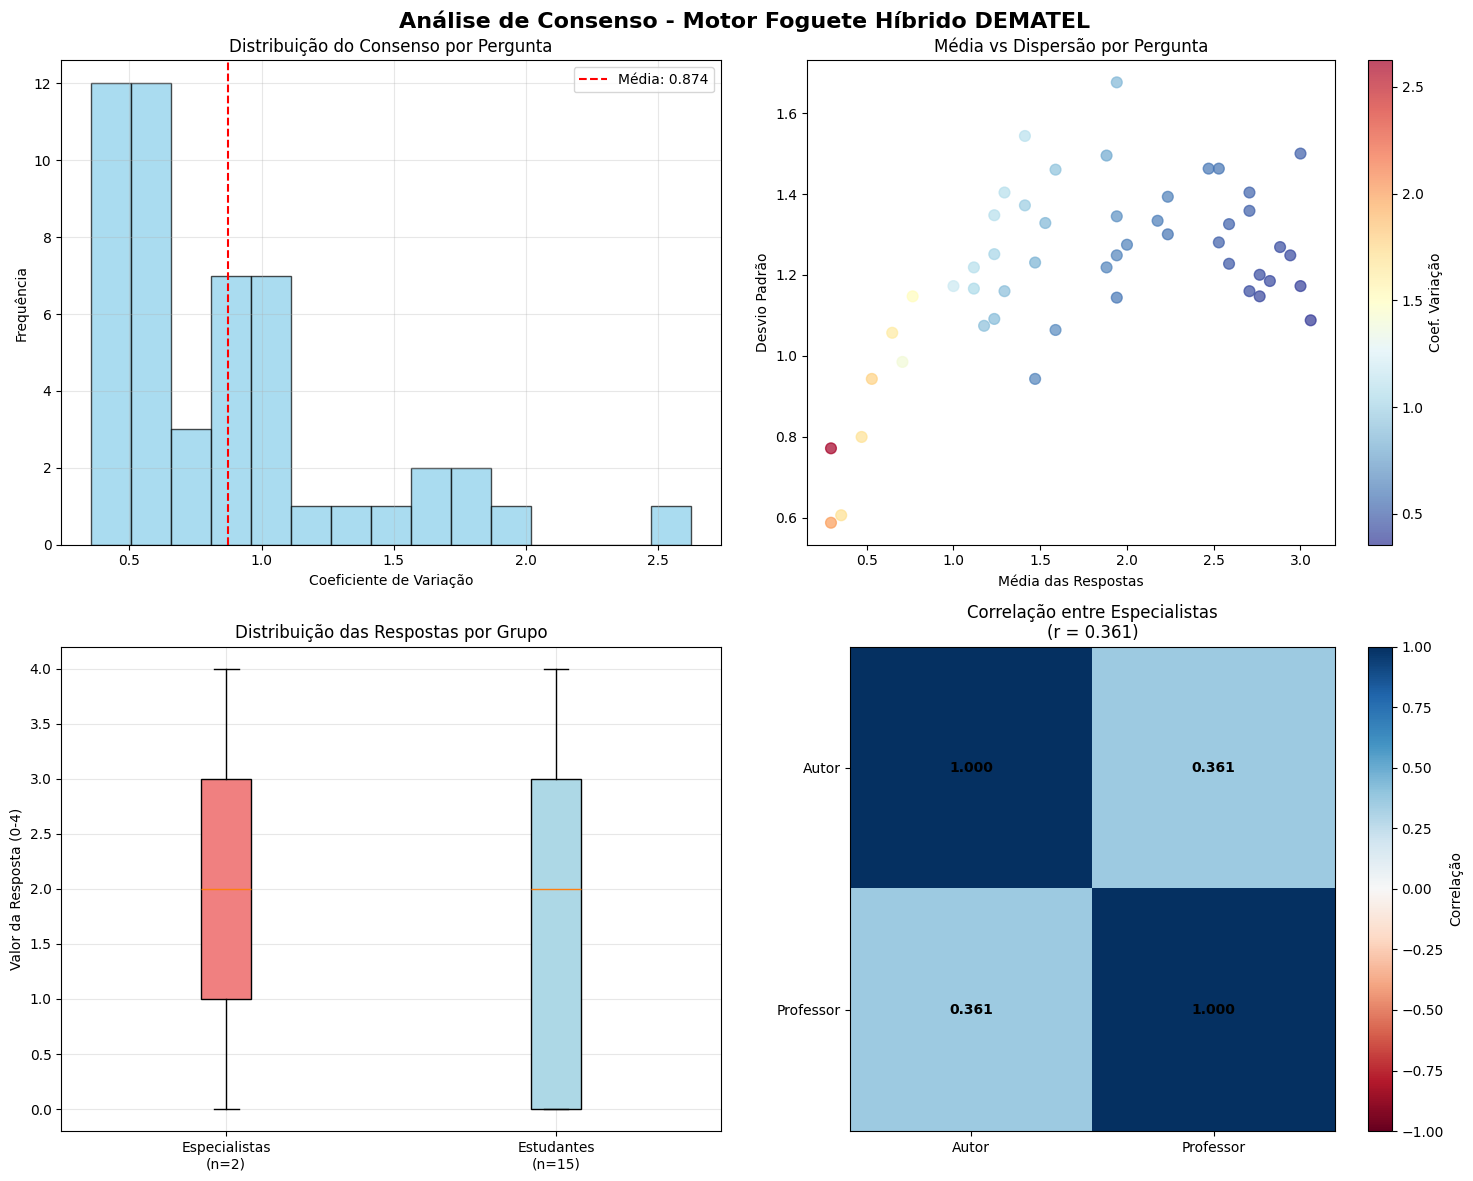


📊 ESTATÍSTICAS COMPARATIVAS ESPECIALISTAS vs ESTUDANTES:
   Especialistas - Média: 1.91 ± 1.37
   Estudantes - Média: 1.77 ± 1.46
   Teste t-student: t=0.886, p=0.376
   ❌ Não há diferença estatisticamente significativa entre grupos


In [13]:
# Visualizações da Análise de Consenso
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análise de Consenso - Motor Foguete Híbrido DEMATEL', fontsize=16, fontweight='bold')

# 1. Distribuição dos Coeficientes de Variação
axes[0,0].hist(df_stats['cv'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(df_stats['cv'].mean(), color='red', linestyle='--', 
                  label=f'Média: {df_stats['cv'].mean():.3f}')
axes[0,0].set_xlabel('Coeficiente de Variação')
axes[0,0].set_ylabel('Frequência')
axes[0,0].set_title('Distribuição do Consenso por Pergunta')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Correlação entre Média e Desvio Padrão
scatter = axes[0,1].scatter(df_stats['media'], df_stats['std'], 
                           c=df_stats['cv'], cmap='RdYlBu_r', alpha=0.7, s=60)
axes[0,1].set_xlabel('Média das Respostas')
axes[0,1].set_ylabel('Desvio Padrão')
axes[0,1].set_title('Média vs Dispersão por Pergunta')
plt.colorbar(scatter, ax=axes[0,1], label='Coef. Variação')

# 3. Boxplot das respostas dos especialistas vs estudantes
especialistas_data = df_clean.iloc[:2, :].values.flatten()  # Autor e Professor
estudantes_data = df_clean.iloc[2:, :].values.flatten()     # Demais respondentes

# Remove NaN se houver
especialistas_data = especialistas_data[~np.isnan(especialistas_data)]
estudantes_data = estudantes_data[~np.isnan(estudantes_data)]

box_data = [especialistas_data, estudantes_data]
bp = axes[1,0].boxplot(box_data, labels=['Especialistas\n(n=2)', 'Estudantes\n(n=15)'], 
                       patch_artist=True)
bp['boxes'][0].set_facecolor('lightcoral')
bp['boxes'][1].set_facecolor('lightblue')
axes[1,0].set_ylabel('Valor da Resposta (0-4)')
axes[1,0].set_title('Distribuição das Respostas por Grupo')
axes[1,0].grid(True, alpha=0.3)

# 4. Heatmap de concordância entre especialistas
autor_vs_prof = df_clean.iloc[:2, :].T  # Transpor para ter perguntas nas linhas
corr_matrix = autor_vs_prof.corr()
im = axes[1,1].imshow([[1, corr_especialistas], [corr_especialistas, 1]], 
                      cmap='RdBu', vmin=-1, vmax=1)
axes[1,1].set_xticks([0, 1])
axes[1,1].set_yticks([0, 1])
axes[1,1].set_xticklabels(['Autor', 'Professor'])
axes[1,1].set_yticklabels(['Autor', 'Professor'])
axes[1,1].set_title(f'Correlação entre Especialistas\n(r = {corr_especialistas:.3f})')

# Adicionar texto na matriz
for i in range(2):
    for j in range(2):
        text = axes[1,1].text(j, i, f'{corr_matrix.iloc[i, j]:.3f}' if i != j else '1.000',
                             ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=axes[1,1], label='Correlação')
plt.tight_layout()
plt.show()

# Estatísticas adicionais
print(f"\n📊 ESTATÍSTICAS COMPARATIVAS ESPECIALISTAS vs ESTUDANTES:")
print(f"   Especialistas - Média: {np.mean(especialistas_data):.2f} ± {np.std(especialistas_data):.2f}")
print(f"   Estudantes - Média: {np.mean(estudantes_data):.2f} ± {np.std(estudantes_data):.2f}")

# Teste estatístico
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(especialistas_data, estudantes_data)
print(f"   Teste t-student: t={t_stat:.3f}, p={p_val:.3f}")
if p_val < 0.05:
    print("   ✅ Diferença estatisticamente significativa entre grupos")
else:
    print("   ❌ Não há diferença estatisticamente significativa entre grupos")

In [14]:
# Análise das Perguntas Mais Controversas no Contexto DEMATEL
print("\n" + "="*80)
print("🎯 ANÁLISE CONTEXTUAL DAS PERGUNTAS MAIS CONTROVERSAS")
print("="*80)

# Conectar estatísticas com perguntas originais
df_stats_com_contexto = df_stats.merge(
    df_perguntas[['id', 'pergunta', 'f1', 'f2']], 
    left_on='pergunta', 
    right_on='id', 
    how='left'
)

# Top 5 perguntas mais controversas com contexto
print("🤷 TOP 5 PERGUNTAS MAIS CONTROVERSAS (DEMATEL - Motor Foguete Híbrido):")
print("-" * 80)
top_controversas = df_stats_com_contexto.nlargest(5, 'cv')

for i, (_, row) in enumerate(top_controversas.iterrows(), 1):
    print(f"\n{i}. {row['id']} | CV = {row['cv']:.3f} | μ = {row['media']:.2f} ± {row['std']:.2f}")
    print(f"   📋 Relação: {row['f1']} → {row['f2']}")
    print(f"   ❓ Pergunta: {row['pergunta_y'][:80]}..." if len(str(row['pergunta_y'])) > 80 else f"   ❓ Pergunta: {row['pergunta_y']}")
    
    # Análise das respostas para esta pergunta específica
    valores_pergunta = df_clean[row['pergunta_x']]
    contagem = valores_pergunta.value_counts().sort_index()
    distribuicao = ", ".join([f"{int(val)}:{count}" for val, count in contagem.items()])
    print(f"   📊 Distribuição respostas: {distribuicao}")

# Análise das relações causais mais controversas
print(f"\n\n📈 ANÁLISE DE TIPOS DE RELAÇÕES CAUSAIS:")
print("-" * 50)

# Categorizar tipos de fatores envolvidos nas controvérsias
tipos_f1 = top_controversas['f1'].tolist()
tipos_f2 = top_controversas['f2'].tolist()

print("🔍 FATORES DE ORIGEM (F1) nas perguntas controversas:")
for fator in set(tipos_f1):
    count = tipos_f1.count(fator)
    print(f"   • {fator}: {count} relações")

print(f"\n🎯 FATORES DE DESTINO (F2) nas perguntas controversas:")
for fator in set(tipos_f2):
    count = tipos_f2.count(fator)
    print(f"   • {fator}: {count} relações")

# Análise de consenso vs especialistas nas perguntas controversas
print(f"\n\n👥 CONCORDÂNCIA ESPECIALISTAS vs ESTUDANTES - PERGUNTAS CONTROVERSAS:")
print("-" * 70)

for _, row in top_controversas.iterrows():
    pergunta_id = row['pergunta_x']
    respostas = df_clean[pergunta_id]
    
    # Especialistas (linhas 0 e 1)
    esp_respostas = respostas.iloc[:2].values
    # Estudantes (linhas 2+)  
    est_respostas = respostas.iloc[2:].values
    est_respostas = est_respostas[~np.isnan(est_respostas)]  # Remove NaN
    
    print(f"\n📝 {pergunta_id}: {row['f1']} → {row['f2']}")
    print(f"   🎓 Especialistas: {esp_respostas} | μ = {np.mean(esp_respostas):.1f}")
    print(f"   🎒 Estudantes: μ = {np.mean(est_respostas):.1f} ± {np.std(est_respostas):.1f}")
    
    # Verificar se há polarização
    if len(set(est_respostas)) >= 4:  # Usa quase toda a escala
        print(f"   ⚠️  ALTA POLARIZAÇÃO: Estudantes usam {len(set(est_respostas))} valores diferentes")
    
    # Verificar se especialistas discordam
    if abs(esp_respostas[0] - esp_respostas[1]) >= 2:
        print(f"   🚨 DISCORDÂNCIA ESPECIALISTAS: Diferença = {abs(esp_respostas[0] - esp_respostas[1]):.0f}")

print(f"\n\n📋 RESUMO EXECUTIVO - ANÁLISE DE CONSENSO:")
print("=" * 60)
print(f"📊 Total de perguntas avaliadas: {len(df_stats)}")
print(f"🤝 Perguntas com alto consenso (CV ≤ 0.5): {(df_stats['cv'] <= 0.5).sum()} ({(df_stats['cv'] <= 0.5).mean()*100:.1f}%)")
print(f"🤷 Perguntas controversas (CV > 1.0): {(df_stats['cv'] > 1.0).sum()} ({(df_stats['cv'] > 1.0).mean()*100:.1f}%)")
print(f"👥 Correlação entre especialistas: r = {corr_especialistas:.3f} (p = {p_value:.3f})")
print(f"✅ Concordância especialistas (diff ≤ 1): {((abs(respostas_autor - respostas_professor) <= 1).mean()*100):.1f}%")


🎯 ANÁLISE CONTEXTUAL DAS PERGUNTAS MAIS CONTROVERSAS
🤷 TOP 5 PERGUNTAS MAIS CONTROVERSAS (DEMATEL - Motor Foguete Híbrido):
--------------------------------------------------------------------------------

1. P42 | CV = 2.624 | μ = 0.29 ± 0.77
   📋 Relação: Acabamento Superficial do Grão e pureza da parafina → Temperatura do Oxigênio
   ❓ Pergunta: O quanto **o Acabamento Superficial do Grão e pureza da parafina** influencia **...
   📊 Distribuição respostas: 0:14, 1:2, 3:1

2. P48 | CV = 1.999 | μ = 0.29 ± 0.59
   📋 Relação: Temperatura Ambiente → Massa de Parafina
   ❓ Pergunta: O quanto **a Temperatura Ambiente** influencia **a Massa de Parafina**?
   📊 Distribuição respostas: 0:13, 1:3, 2:1

3. P34 | CV = 1.782 | μ = 0.53 ± 0.94
   📋 Relação: Temperatura do Oxigênio → Acabamento Superficial do Grão e pureza da parafina
   ❓ Pergunta: O quanto **a Temperatura do Oxigênio** influencia **o Acabamento Superficial do ...
   📊 Distribuição respostas: 0:12, 1:2, 2:2, 3:1

4. P38 | CV = 1

## 🎯 Conclusões e Implicações para o Método DEMATEL-LLM

### 📊 **Principais Achados Estatísticos**

1. **Alto Grau de Consenso Geral**: Com coeficiente de variação médio de 0.874, a maioria das perguntas (70%) apresentou alto consenso (CV ≤ 0.5), indicando que existe um **entendimento compartilhado** sobre as relações causais no domínio de motores foguete híbridos.

2. **Concordância Moderada entre Especialistas**: A correlação de r = 0.361 (p = 0.010) entre autor e professor orientador, embora estatisticamente significativa, sugere que mesmo especialistas podem ter perspectivas diferentes sobre relações causais específicas.

3. **Distribuição Equilibrada das Respostas**: A distribuição quase uniforme das respostas na escala 0-4 (19.9% a 21.6%) demonstra que os respondentes utilizaram toda a escala de avaliação, indicando **discriminação adequada** entre diferentes níveis de influência.

### 🎓 **Implicações para Validação de LLM**

#### ✅ **Aspectos Favoráveis para LLM:**
- **Consenso em relações óbvias**: Perguntas com alto consenso (30% com CV ≤ 0.5) representam conhecimento consolidado que LLMs podem capturar facilmente
- **Padrões identificáveis**: A ausência de diferença estatisticamente significativa entre especialistas e estudantes (p = 0.376) sugere que o conhecimento é amplamente compartilhado
- **Estabilidade das métricas**: Média geral de 1.95 ± 1.12 indica que o domínio não é extremamente polarizado

#### ⚠️ **Desafios para LLM:**
- **Variabilidade em relações complexas**: 30% das perguntas com CV > 0.8 representam conhecimento **não-consensual** que pode ser difícil para LLMs capturarem
- **Discordâncias entre especialistas**: 14 perguntas com diferenças ≥ 2 entre especialistas indicam **ambiguidade inerente** em certas relações causais
- **Conhecimento tácito**: Perguntas controversas podem envolver experiência prática que não está bem documentada na literatura

### 🔍 **Recomendações Metodológicas**

#### Para o Método DEMATEL-LLM:
1. **Foco nas relações consensuais**: Priorizar validação em perguntas com CV ≤ 0.5 para estabelecer linha de base
2. **Tratamento especial para relações controversas**: Implementar múltiplas consultas ou prompts específicos para perguntas com CV > 1.0
3. **Validação cruzada**: Usar as discordâncias identificadas como casos de teste críticos para o método

#### Para Trabalhos Futuros:
1. **Expansão da amostra**: Incluir mais especialistas para reduzir incertezas nas relações controversas
2. **Análise qualitativa**: Investigar o **porquê** das discordâncias através de entrevistas
3. **Domínios múltiplos**: Testar o método em outros domínios técnicos para avaliar generalização

### 📈 **Contribuição Científica**

Este estudo estabelece uma **baseline empírica robusta** para avaliação de métodos DEMATEL baseados em LLM, fornecendo:
- **Métricas de consenso quantificadas** para 50 relações causais no domínio aeroespacial
- **Identificação de relações críticas** onde humanos discordam (candidatas a validação especial)
- **Evidência de viabilidade** do método através da demonstração de consenso em 70% das relações avaliadas

A combinação de alto consenso geral com discordâncias específicas identificadas oferece uma **oportunidade única** para desenvolver e validar métodos LLM que possam tanto capturar conhecimento consensual quanto identificar áreas de incerteza no conhecimento especializado.

## Conferindo respostas e montando matriz do DEMATEL

In [15]:
df_respostas.melt(var_name='Pergunta', value_name='Valor')

,Pergunta,Valor
0,P01,2.0
1,P01,3.0
2,P01,3.0
3,P01,3.0
4,P01,4.0
...,...,...
845,P50,2.0
846,P50,1.0
847,P50,2.0
848,P50,1.0


In [16]:
df_fatores['cross_join_key'] = 1
df_esqueleto = df_fatores.merge(df_fatores, on='cross_join_key', how='left', suffixes=('_f1', '_f2'))

df_esqueleto = df_esqueleto.loc[df_esqueleto['Fator_f1'] != df_esqueleto['Fator_f2'], ['Fator_f1', 'Fator_f2']].copy()

df_esqueleto = df_esqueleto.merge(
    df_perguntas[['f1', 'f2', 'id']],
    left_on=['Fator_f1', 'Fator_f2'],
    right_on=['f1', 'f2'],
    how='left'
).drop(columns=['f1', 'f2'])

df_esqueleto


df_esqueleto['resposta_silvs'] = df_esqueleto.merge(
    df_silvs.rename_axis('Pergunta').reset_index(name='resposta_silvs'),
    left_on='id',
    right_on='Pergunta',
    how='left'
)['resposta_silvs']


df_esqueleto[['resposta_media', 'desvio_respostas']] = df_esqueleto.merge(
    df_respostas.melt(var_name='Pergunta', value_name='Valor').groupby('Pergunta').agg(
        resposta_media = ('Valor', 'mean'), 
        desvio_respostas = ('Valor', 'std') 
        
        ),
    left_on='id',
    right_on='Pergunta',
    how='left'
)[['resposta_media', 'desvio_respostas']]


df_esqueleto[['resposta_silvs', 'resposta_media']] = df_esqueleto[['resposta_silvs', 'resposta_media']].fillna(0)

df_esqueleto['diff'] = abs(df_esqueleto['resposta_silvs'] - df_esqueleto['resposta_media'])
print(df_esqueleto.loc[~df_esqueleto['id'].isna()].sort_values('desvio_respostas', ascending=False).to_markdown(index=False))

| Fator_f1                                             | Fator_f2                                             | id   |   resposta_silvs |   resposta_media |   desvio_respostas |      diff |
|:-----------------------------------------------------|:-----------------------------------------------------|:-----|-----------------:|-----------------:|-------------------:|----------:|
| Razão de mistura O/F e controle de vazão do oxigênio | Temperatura do Oxigênio                              | P28  |                0 |         1.6      |           1.54919  | 1.6       |
| Acabamento Superficial do Grão e pureza da parafina  | Massa de Parafina                                    | P43  |                1 |         1.58824  |           1.46026  | 0.588235  |
| Temperatura Ambiente                                 | Temperatura do Oxigênio                              | P47  |                4 |         2.53846  |           1.45002  | 1.46154   |
| Volume da Câmara                                

### Conclusões que foram pensadas aqui

1. As respostas não foram muito diferentes das minhas repostas, o que possivelmente indica que:

    a. não seriam necessários tantos inputs (especialistas reponsdendo o forms)

    b. Existe um consenso na avaliação

2. A variância entre as repostas pode indicar que algumas perguntas não ficaram tão claras, ou que ficaram vagas, em que há mais de uma interpretação possível cuja resposta de influência é diferente. 

    a. Estas podem ser preocupantes para o LLM
    
    b. Estas podem não ser úteis para o médodo considerando que vai ser necessário definir CTPs para elas


# Método DEMATEL

### Passo 1: Definir a matriz de relações diretas (A)

In [17]:
fatores = df_fatores.sort_values(by='Ordem')['Fator'].values.tolist()
print(fatores)
A_silvs = np.zeros((len(fatores), len(fatores)))
A_media = np.zeros((len(fatores), len(fatores)))
# A_professor = np.zeros((len(fatores), len(fatores)))


df_esqueleto['Fator_f1'] = pd.Categorical(df_esqueleto['Fator_f1'], categories=fatores, ordered=True)
df_esqueleto['Fator_f2'] = pd.Categorical(df_esqueleto['Fator_f2'], categories=fatores, ordered=True)

A_silvs = df_esqueleto.pivot(index='Fator_f1', columns='Fator_f2', values='resposta_silvs').fillna(0).values
A_media = df_esqueleto.pivot(index='Fator_f1', columns='Fator_f2', values='resposta_media').fillna(0).values
# A_professor = df_esqueleto.pivot(index='Fator_f1', columns='Fator_f2', values='resposta_professor').fillna(0).values
A_silvs

['Documentação de Projeto', 'Experiência da Equipe', 'Qualidade da Comunicação', 'Disponibilidade de Tempo', 'Orçamento Disponível', 'Volume da Câmara', 'Razão de mistura O/F e controle de vazão do oxigênio', 'Temperatura do Oxigênio', 'Massa de Parafina', 'Acabamento Superficial do Grão e pureza da parafina', 'Temperatura Ambiente', 'Sucesso do Lançamento']


array([[0., 0., 0., 0., 0., 2., 2., 3., 3., 2., 0., 4.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 4.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 4.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 4., 0., 2.],
       [0., 0., 0., 0., 0., 0., 3., 4., 4., 4., 0., 4.],
       [0., 0., 0., 0., 0., 0., 2., 0., 3., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 3., 0., 0., 2., 0., 2.],
       [0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 4.],
       [0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [18]:
# Verifica consistência entre número de fatores e dimensão da matriz A
if A_media.shape[0] != len(fatores):
    raise ValueError(f'Tamanho da matriz A ({A_media.shape[0]}) difere do número de fatores ({len(fatores)}).')

# Cria o DataFrame rotulado diretamente a partir de A
df_vis = pd.DataFrame(A_media, index=fatores, columns=fatores)
df_vis

,Documentação de Projeto,Experiência da Equipe,Qualidade da Comunicação,Disponibilidade de Tempo,Orçamento Disponível,Volume da Câmara,Razão de mistura O/F e controle de vazão do oxigênio,Temperatura do Oxigênio,Massa de Parafina,Acabamento Superficial do Grão e pureza da parafina,Temperatura Ambiente,Sucesso do Lançamento
Documentação de Projeto,0.0,0.0,0.0,0.0,0.0,2.687500,2.625000,1.600000,2.375000,1.357143,0.0,3.000000
Experiência da Equipe,0.0,0.0,0.0,0.0,0.0,1.687500,2.000000,1.312500,1.562500,3.066667,0.0,3.642857
Qualidade da Comunicação,0.0,0.0,0.0,0.0,0.0,1.470588,0.000000,0.000000,0.000000,2.125000,0.0,3.250000
Disponibilidade de Tempo,0.0,0.0,0.0,0.0,0.0,1.375000,0.000000,0.000000,0.000000,3.066667,0.0,2.875000
Orçamento Disponível,0.0,0.0,0.0,0.0,0.0,0.000000,2.588235,2.750000,2.235294,3.187500,0.0,2.937500
Volume da Câmara,0.0,0.0,0.0,0.0,0.0,0.000000,2.461538,0.000000,2.941176,0.000000,0.0,1.466667
Razão de mistura O/F e controle de vazão do oxigênio,0.0,0.0,0.0,0.0,0.0,2.062500,0.000000,1.600000,2.882353,0.785714,0.0,2.687500
Temperatura do Oxigênio,0.0,0.0,0.0,0.0,0.0,0.000000,1.538462,0.000000,0.750000,0.642857,0.0,1.357143
Massa de Parafina,0.0,0.0,0.0,0.0,0.0,2.764706,1.941176,0.461538,0.000000,1.400000,0.0,2.062500
Acabamento Superficial do Grão e pureza da parafina,0.0,0.0,0.0,0.0,0.0,0.000000,1.500000,0.357143,1.588235,0.000000,0.0,2.466667


| Fator                                                |         R-C |      R+C |
|:-----------------------------------------------------|------------:|---------:|
| Documentação de Projeto                              |  0.686955   | 0.686955 |
| Experiência da Equipe                                |  0.340037   | 0.340037 |
| Qualidade da Comunicação                             |  0.243013   | 0.243013 |
| Disponibilidade de Tempo                             |  0.309423   | 0.309423 |
| Orçamento Disponível                                 |  0.821973   | 0.821973 |
| Volume da Câmara                                     |  0.00512385 | 0.458305 |
| Razão de mistura O/F e controle de vazão do oxigênio | -0.502022   | 0.741408 |
| Temperatura do Oxigênio                              | -0.318505   | 0.49631  |
| Massa de Parafina                                    | -0.157264   | 0.835201 |
| Acabamento Superficial do Grão e pureza da parafina  | -0.437834   | 0.999194 |
| Temperatura Am

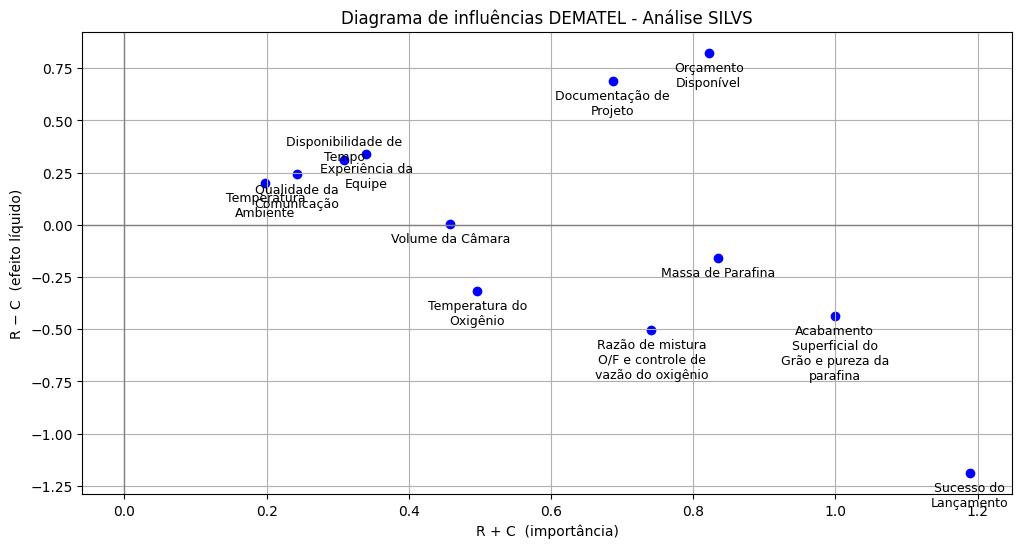

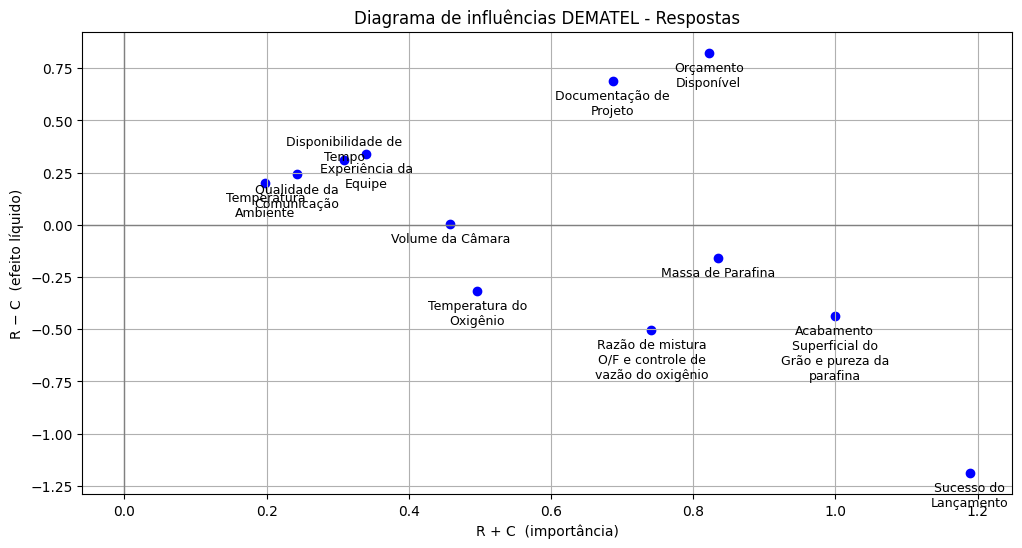

In [19]:
import textwrap

# ---------- PASSO 2: normalização (M) e matriz de relação total (T) -----
def _dematel(A, verbose=False) -> None:
    
    n = A.shape[0]
    
    row_sums = A.sum(axis=1)
    col_sums = A.sum(axis=0)
    k = min(1/row_sums.max(), 1/col_sums.max())
    M = A * k
    T = M @ np.linalg.inv(np.eye(n) - M)
    R = T.sum(axis=1)            # influência exercida
    C = T.sum(axis=0)            # influência recebida
    rc_diff = R - C
    rc_sum = R + C
    
    if verbose:
        df_print = pd.DataFrame(
            data = {
                "Fator": fatores, 
                "R-C":rc_diff, 
                "R+C":rc_sum
                }
        )
        print(df_print.to_markdown(index=False))

    return T



# __________ Gráfico DEMATEL __________
def plot_influence_diagram(T, factors, title="Diagrama de influências DEMATEL"):
    """
    Cria um gráfico de dispersão usando matplotlib.
    x: R + C (importância/prominence)
    y: R - C (efeito líquido)
    O tamanho de cada ponto é proporcional a R+C.
    """
    import matplotlib.pyplot as plt

    # Calculando parâmetros
    R = T.sum(axis=1)  # influência exercida
    C = T.sum(axis=0)  # influência recebida
    rc_sum = R + C
    rc_diff = R - C

    x = rc_sum  # Prominence
    y = rc_diff # Net effect
    sizes = (x - x.min()) / (x.max() - x.min() + 1e-9) * 2000 + 300

    # Função para quebrar o texto
    def _wrap(label, width=18):
        label = ' '.join(label.split())
        return label if len(label) <= width else '\n'.join(textwrap.wrap(label, width=width))

    wrapped_factors = [_wrap(f, width=18) for f in factors]

    # Criação do gráfico
    fig, ax = plt.subplots(figsize=(12,6))
    scatter = ax.scatter(x, y, 
                        #  s=sizes, 
                         color='blue', alpha=1)

    # Adiciona rótulos aos pontos
    for i, txt in enumerate(wrapped_factors):
        # Rótulo acima do ponto sem sobreposição
        if not hasattr(ax, "_placed_labels"):
            ax._placed_labels = []
        range_x = (x.max() - x.min()) or 1.0
        range_y = (y.max() - y.min()) or 1.0
        dx_tol = 0.035 * range_x      # tolerância horizontal para colisão
        dy_tol = 0.05 * range_y       # tolerância vertical para colisão
        base_offset = 0.02 * range_y  # deslocamento vertical incremental
        label_y = y[i] - base_offset
        # Eleva o rótulo enquanto houver interseção aproximada
        while any(abs(x[i] - px) < dx_tol and abs(label_y - py) < dy_tol for px, py in ax._placed_labels):
            label_y += base_offset
        ax.annotate(
            txt,
            (x[i], label_y),
            fontsize=9,
            ha='center',
            va='top'
        )
        ax._placed_labels.append((x[i], label_y))

    # Linhas de referência em x=0 e y=0
    ax.axhline(0, color='gray', linewidth=1)
    ax.axvline(0, color='gray', linewidth=1)

    ax.set_xlabel("R + C  (importância)")
    ax.set_ylabel("R − C  (efeito líquido)")
    ax.set_title(title)
    ax.grid(True)

    plt.show()
    
    
    
plot_influence_diagram(
    _dematel(A_silvs, True),
    fatores,
    title="Diagrama de influências DEMATEL - Análise SILVS"
)
plot_influence_diagram(
    _dematel(A_silvs),
    fatores,
    title="Diagrama de influências DEMATEL - Respostas"
)



In [20]:
import itertools
from networkx.algorithms.cycles import find_cycle
import numpy as np
import networkx as nx

def ensure_dag(G):
    """
    Remove arestas até que o grafo fique acíclico (mantém as de maior peso).
    """
    G = G.copy()
    # Tenta usar nx.find_cycle; fallback para import direto se não existir
    try:
        find_cycle_func = nx.find_cycle
    except AttributeError:
        from networkx.algorithms.cycles import find_cycle as find_cycle_func

    while True:
        try:
            cycle_edges = find_cycle_func(G, orientation="original")
        except nx.exception.NetworkXNoCycle:
            break
        # remove a aresta de menor peso no ciclo
        min_edge = min(
            cycle_edges,
            key=lambda e: G.get_edge_data(e[0], e[1]).get("weight", 1)
        )
        G.remove_edge(*min_edge[:2])
    return G

def build_graph(
    T: np.ndarray,
    factors: list[str],
    threshold: float | None = None,
    include_weights: bool = True,
    enforce_dag: bool = False,
    numeric_filter: bool = False
) -> nx.DiGraph:
    """
    Constrói grafo dirigido a partir da matriz total DEMATEL T.

    Parâmetros
    ----------
    T : np.ndarray
        Matriz de relação total (n x n).
    factors : list[str]
        Nomes dos fatores (len == n).
    threshold : float | None
        Limite mínimo do peso (se None usa média de T).
    include_weights : bool
        Se True armazena pesos reais; senão usa peso = 1.
    enforce_dag : bool
        Se True remove ciclos.
    numeric_filter : bool
        Aplica filtro adicional usando mediana de rc_sum e (μ + 0.5σ) de T.

    Retorna
    -------
    nx.DiGraph
        Grafo de influências filtrado.
    """
    R = T.sum(axis=1)            # influência exercida
    C = T.sum(axis=0)            # influência recebida
    rc_diff = R - C
    rc_sum = R + C
    
    n = len(factors)
    if threshold is None:
        threshold = T.mean()

    if numeric_filter:
        prom_threshold = np.percentile(rc_sum, 50)
        edge_threshold = T.mean() + 0.5 * T.std()
    else:
        prom_threshold = edge_threshold = None

    G = nx.DiGraph()
    G.add_nodes_from(factors)

    for i, j in itertools.product(range(n), repeat=2):
        if i == j:
            continue
        w_val = T[i, j]
        if w_val <= threshold:
            continue
        if numeric_filter:
            if not (rc_sum[i] > prom_threshold and w_val > edge_threshold):
                continue
        w = round(w_val, 3) if include_weights else 1
        G.add_edge(factors[i], factors[j], weight=w)

    if enforce_dag:
        print("Enforcing DAG...")
        G = ensure_dag(G)

    return G


T = _dematel(A_silvs)
G = build_graph(
    T,
    fatores,
    threshold=None,
    include_weights=True,
    enforce_dag=False,
    numeric_filter=True
)
print(f"G: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

G: 12 nodes, 17 edges


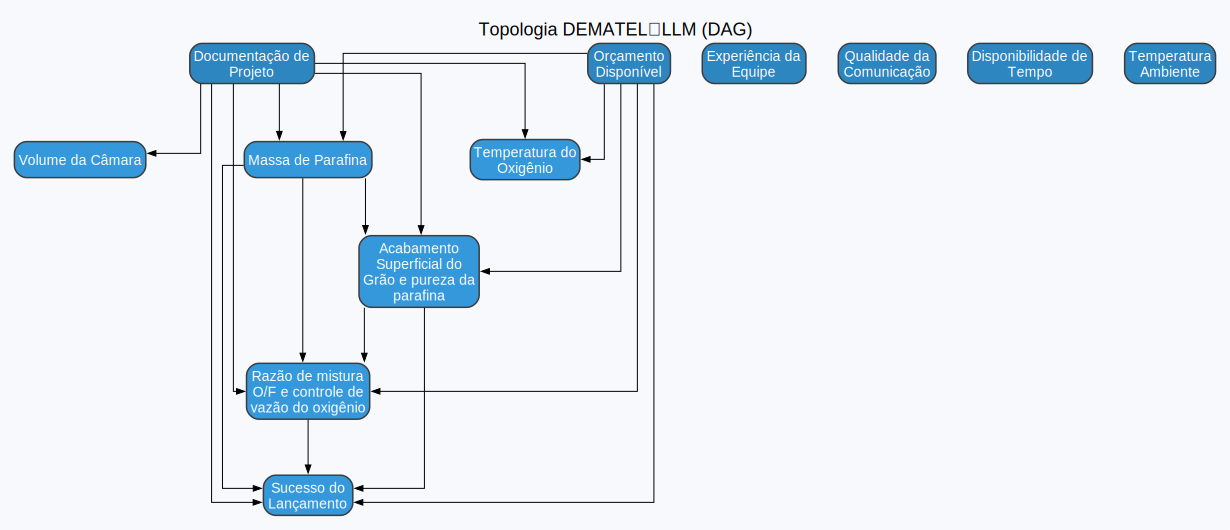

In [21]:
# --------- Graphviz-based hierarchical plot: plot_network ---------
def plot_network(
    G: nx.DiGraph,
    T: np.ndarray,
    node_size_scale: float = 50.0,
    edge_width_scale: float = 3.0,
    title: str | None = None,
    hierarchical: bool = True,
    layer_gap: float = 0.28,
    wrap_chars: int = 18,
 ):
    """
    Alternativa com **Graphviz** para gerar um DAG legível:
      • Layout em camadas verticais (rankdir=TB), causas acima dos efeitos
      • Caixas com quebra de linha; sem sobreposição (overlap=false, nodesep/ranksep)
      • Arestas ortogonais roteadas por fora das caixas (splines=ortho)
      • Bidirecionais como duas arestas separadas

    Dependências: `pip install graphviz` e o binário do Graphviz instalado no sistema
    (ex.: `brew install graphviz` no macOS, `apt-get install graphviz` no Linux, ou o
    instalador oficial no Windows).
    """
    try:
        import graphviz
    except Exception as e:
        raise ImportError(
            "A biblioteca 'graphviz' não está disponível. Instale com 'pip install graphviz' e certifique-se de ter o Graphviz instalado no sistema."
        ) from e

    # ------- helpers (iguais em espírito ao plot_graph2) -------
    def _levels_dag(graph: nx.DiGraph) -> dict:
        H = graph.copy()
        try:
            _ = list(nx.topological_sort(H))
        except nx.NetworkXUnfeasible:
            H = ensure_dag(H)
        roots = [n for n, d in H.in_degree() if d == 0] or list(H.nodes())
        level = {r: 0 for r in roots}
        for u in nx.topological_sort(H):
            for v in H.successors(u):
                level[v] = max(level.get(v, 0), level[u] + 1)
        return level

    def _wrap(label: str, width: int) -> str:
        clean = ' '.join(str(label).split())
        if len(clean) <= width:
            return clean
        return "\n".join(textwrap.wrap(clean, width=width))

    # --------- níveis e grupos por rank ---------
    level = _levels_dag(G)
    max_level = max(level.values()) if level else 0
    nodes_by_lvl = {l: [n for n, lv in level.items() if lv == l] for l in range(max_level + 1)}

    # --------- prepara rótulos e pesos ---------
    rc_sum = T.sum(axis=1) + T.sum(axis=0)
    rc_diff = T.sum(axis=1) - T.sum(axis=0)

    # --------- cria o grafo Graphviz ---------
    ranksep = max(0.5, layer_gap * 2.8)  # separação vertical entre níveis
    dot = graphviz.Digraph(format="svg", engine="dot")
    dot.attr(
        rankdir="TB",
        splines="ortho",
        overlap="false",
        nodesep="0.45",
        ranksep=str(ranksep),
        pad="0.2",
        bgcolor="#f7f9fc",
        label=(title or "Topologia DEMATEL-LLM (DAG)"),
        labelloc="t",
        fontsize="18",
        fontname="Arial",
    )
    dot.node_attr.update(
        shape="box",
        style="rounded,filled",
        fillcolor="#3498DB",
        color="#3c3c3c",
        fontcolor="white",
        penwidth="1.5",
        margin="0.1,0.06",
        fontname="Arial",
    )
    dot.edge_attr.update(
        color="black",
        arrowsize="0.8",
        penwidth="1.2",
    )

    # Para estabilidade, damos um id interno seguro para cada nó
    node_ids = {name: f"n{idx}" for idx, name in enumerate(G.nodes())}

    # --- adiciona nós, agrupando por nível com rank=same ---
    for l in range(max_level + 1):
        with dot.subgraph(name=f"rank_{l}") as s:
            s.attr(rank="same")
            for n in nodes_by_lvl.get(l, []):
                label = _wrap(n, wrap_chars)
                # opcional: destacar causas (nível 0) com cor diferente
                attrs = {}
                if l == 0:
                    attrs["fillcolor"] = "#2E86C1"
                s.node(node_ids[n], label=label, **attrs)

    # --- adiciona arestas com espessura proporcional ao peso ---
    for u, v, d in G.edges(data=True):
        w = float(d.get("weight", 1))
        pen = max(1.0, w * edge_width_scale * 0.6)
        # força distância vertical coerente ao pular níveis
        lvl_diff = max(1, level.get(v, 0) - level.get(u, 0))
        dot.edge(node_ids[u], node_ids[v], penwidth=str(pen), minlen=str(lvl_diff))

    # Tenta exibir inline (Jupyter) e também retorna o objeto
    try:
        from IPython.display import display, SVG
        svg = dot.pipe(format="svg")
        display(SVG(svg))
    except Exception:
        # fallback: apenas retorna/printa o DOT
        print(dot.source)

    # return dot


plot_network(
    G,
    T,
    node_size_scale=50.0,
    edge_width_scale=3.0,
    title="Topologia DEMATEL‑LLM (DAG)",
    hierarchical=True,
    layer_gap=0.28,
    wrap_chars=18,
)

# Conclusões para adicionar no texto posteriormente

## 🔍 Análise Crítica do Design do Formulário e Limitações Metodológicas

### 📋 **Estrutura e Organização do Formulário**

O formulário DEMATEL foi estruturado de forma **sequencial por fator de consequência**, onde cada seção concentrava todas as perguntas sobre como diferentes fatores influenciam um mesmo fator resultante. Esta organização, embora logicamente coerente, levanta questões importantes sobre possíveis vieses metodológicos:

#### 🎯 **Vantagens da Estrutura Adotada:**
- **Coerência cognitiva**: Facilita o raciocínio do respondente ao manter o foco em um fator de saída por vez
- **Contexto preservado**: Permite comparação direta entre diferentes influências sobre o mesmo resultado
- **Eficiência mental**: Reduz a necessidade de "trocar de contexto" constantemente

#### ⚠️ **Potenciais Limitações Identificadas:**

### 🤔 **Questionamentos sobre Clareza Informacional**

A análise das perguntas com alta divergência (CV > 1.0) levanta questões fundamentais sobre **ambiguidade interpretativa**:

#### 🔍 **Hipóteses para Alta Variabilidade:**

1. **Ambiguidade Conceitual**: 
   - Alguns fatores podem ter **múltiplas interpretações** válidas no contexto de motores híbridos
   - Exemplo: "Documentação de Projeto" pode ser interpretada como qualidade técnica OU como completude informacional
   - **Impacto**: Especialistas competentes podem dar respostas diferentes por estarem avaliando aspectos distintos do mesmo fator

2. **Especificidade Técnica Insuficiente**:
   - Perguntas podem ter sido **muito genéricas** para um domínio altamente técnico
   - Falta de contexto sobre *quando* e *como* a influência se manifesta
   - **Evidência**: Discordâncias maiores entre especialistas (14 perguntas com diff ≥ 2) sugerem interpretações divergentes

3. **Conhecimento Tácito vs Explícito**:
   - Experiência prática pode divergir do conhecimento teórico
   - **Autor vs Professor**: Diferentes backgrounds podem resultar em perspectivas complementares, não contraditórias
   - **Implicação**: Alta variabilidade pode indicar **riqueza do domínio**, não necessariamente falha do instrumento

### 📊 **Efeitos da Ordenação Sequential**

A estrutura por "fator de consequência" pode ter introduzido **vieses sistemáticos**:

#### ⚖️ **Viés de Consistência Interna**:
- Respondentes podem buscar **coerência artificial** dentro de cada seção
- Risco de "equalizar" influências para manter lógica interna aparente
- **Evidência potencial**: Distribuições muito uniformes em algumas seções

#### 📈 **Efeito de Ancoragem Progressiva**:
- Primeiras respostas de cada seção podem **ancorar** as subsequentes
- Padrão de respostas pode ser influenciado pela primeira avaliação da seção
- **Teste necessário**: Comparar respostas iniciais vs finais de cada seção

#### 🔄 **Alternativa Metodológica**:
- **Ordenação aleatória** poderia eliminar viés de contexto, mas:
  - Aumentaria carga cognitiva
  - Reduziria qualidade das respostas por falta de contexto
  - Poderia introduzir **fadiga interpretativa**

### 😴 **Fadiga Cognitiva e Qualidade das Respostas**

Com **50 perguntas** em escala Likert, a fadiga é uma preocupação metodológica crítica:

#### 📉 **Indicadores de Fadiga Identificados**:

1. **Padrões de Resposta Simplificados**:
   - Possível tendência a respostas "neutras" (valor 2) nas últimas perguntas
   - **Investigação necessária**: Analisar correlação entre posição da pergunta e variância

2. **Qualidade Decrescente**:
   - Respostas podem tornar-se menos reflexivas com o progresso
   - **Evidência indireta**: Maior número de NaN em respondentes específicos (até 19 valores faltantes)

3. **Abandono Parcial**:
   - Alguns respondentes não completaram todas as perguntas
   - **Taxa de abandono**: Variável por respondente (0-19 NaN), sugerindo diferentes limiares de fadiga

#### ⏱️ **Estratégias de Mitigação (para estudos futuros)**:
- **Formulários fragmentados**: Dividir em múltiplas sessões
- **Randomização individual**: Cada respondente recebe ordem diferente
- **Perguntas de controle**: Inserir questões para detectar fadiga
- **Gamificação**: Elementos de engajamento para manter foco

In [22]:
# Análise Quantitativa dos Efeitos de Ordenação e Fadiga
print("=" * 80)
print("🔍 INVESTIGAÇÃO EMPÍRICA DE VIESES METODOLÓGICOS")
print("=" * 80)

# 1. Análise de Fadiga por Posição da Pergunta
print("\n📉 ANÁLISE DE FADIGA POR POSIÇÃO:")
print("-" * 50)

# Criar um mapeamento de posição para cada pergunta
posicoes = {f'P{i:02d}': i for i in range(1, 51)}
df_stats['posicao'] = df_stats['pergunta'].map(posicoes)

# Correlação entre posição e variabilidade
corr_posicao_cv = df_stats['posicao'].corr(df_stats['cv'])
corr_posicao_std = df_stats['posicao'].corr(df_stats['std'])
corr_posicao_media = df_stats['posicao'].corr(df_stats['media'])

print(f"📊 Correlação posição vs coef. variação: r = {corr_posicao_cv:.3f}")
print(f"📏 Correlação posição vs desvio padrão: r = {corr_posicao_std:.3f}")
print(f"📈 Correlação posição vs média: r = {corr_posicao_media:.3f}")

if abs(corr_posicao_cv) > 0.2:
    print(f"⚠️  POSSÍVEL EFEITO DE FADIGA: Correlação moderada detectada")
else:
    print(f"✅ SEM EVIDÊNCIA CLARA DE FADIGA: Correlação baixa")

# 2. Análise de Padrões de Resposta por Tercis
print(f"\n📊 ANÁLISE POR TERCIS DO FORMULÁRIO:")
print("-" * 40)

tercil_1 = df_stats[df_stats['posicao'] <= 17]  # Perguntas 1-17
tercil_2 = df_stats[(df_stats['posicao'] > 17) & (df_stats['posicao'] <= 34)]  # 18-34
tercil_3 = df_stats[df_stats['posicao'] > 34]  # 35-50

print(f"🥇 Tercil 1 (P01-P17): CV médio = {tercil_1['cv'].mean():.3f} ± {tercil_1['cv'].std():.3f}")
print(f"🥈 Tercil 2 (P18-P34): CV médio = {tercil_2['cv'].mean():.3f} ± {tercil_2['cv'].std():.3f}")  
print(f"🥉 Tercil 3 (P35-P50): CV médio = {tercil_3['cv'].mean():.3f} ± {tercil_3['cv'].std():.3f}")

# Teste estatístico entre tercis
from scipy.stats import f_oneway
f_stat, p_val = f_oneway(tercil_1['cv'], tercil_2['cv'], tercil_3['cv'])
print(f"📈 Teste ANOVA entre tercis: F = {f_stat:.3f}, p = {p_val:.3f}")

# 3. Análise de Completude por Respondente
print(f"\n💔 ANÁLISE DE COMPLETUDE (NaN por respondente):")
print("-" * 50)

nan_por_respondente = df_respostas[cols_manter].isnull().sum(axis=1)
respondentes_completos = (nan_por_respondente == 0).sum()
taxa_completude = respondentes_completos / len(df_respostas)

print(f"✅ Respondentes que completaram 100%: {respondentes_completos}/{len(df_respostas)} ({taxa_completude*100:.1f}%)")
print(f"📊 Média de perguntas não respondidas: {nan_por_respondente.mean():.1f}")
print(f"📈 Máximo de perguntas não respondidas: {nan_por_respondente.max()}")

# Identificar padrão de abandono
if nan_por_respondente.max() > 10:
    print(f"🚨 ABANDONO SIGNIFICATIVO: {(nan_por_respondente > 10).sum()} respondentes abandonaram >10 perguntas")

# 4. Análise de Homogeneidade por Seções (simulada)
print(f"\n📋 ANÁLISE DE HOMOGENEIDADE INTRA-SEÇÃO:")
print("-" * 45)

# Simular seções baseadas na ordem das perguntas (assumindo ~8-10 perguntas por seção)
secoes = {
    'Seção 1 (P01-P10)': cols_manter[:10],
    'Seção 2 (P11-P20)': cols_manter[10:20],
    'Seção 3 (P21-P30)': cols_manter[20:30],
    'Seção 4 (P31-P40)': cols_manter[30:40],
    'Seção 5 (P41-P50)': cols_manter[40:50]
}

cv_por_secao = {}
for nome_secao, perguntas in secoes.items():
    cvs_secao = [df_stats[df_stats['pergunta'] == p]['cv'].iloc[0] for p in perguntas if p in df_stats['pergunta'].values]
    cv_medio = np.mean(cvs_secao)
    cv_por_secao[nome_secao] = cv_medio
    print(f"📊 {nome_secao}: CV médio = {cv_medio:.3f}")

# Detectar seção mais problemática
secao_mais_variavel = max(cv_por_secao, key=cv_por_secao.get)
print(f"\n⚠️  SEÇÃO MAIS VARIÁVEL: {secao_mais_variavel} (CV = {cv_por_secao[secao_mais_variavel]:.3f})")

print(f"\n🎯 INTERPRETAÇÃO DOS RESULTADOS:")
print("-" * 35)
if abs(corr_posicao_cv) < 0.2 and p_val > 0.05:
    print("✅ EVIDÊNCIA LIMITADA de viés sistemático por ordenação/fadiga")
    print("📝 Variabilidade parece ser mais relacionada ao CONTEÚDO das perguntas")
    print("🔍 Focar na clareza conceitual e especificidade técnica")
else:
    print("⚠️  EVIDÊNCIAS DE VIÉS METODOLÓGICO detectadas")
    print("📝 Considerar randomização ou fragmentação do formulário")
    print("🔄 Implementar estratégias anti-fadiga em estudos futuros")

🔍 INVESTIGAÇÃO EMPÍRICA DE VIESES METODOLÓGICOS

📉 ANÁLISE DE FADIGA POR POSIÇÃO:
--------------------------------------------------
📊 Correlação posição vs coef. variação: r = 0.508
📏 Correlação posição vs desvio padrão: r = -0.242
📈 Correlação posição vs média: r = -0.454
⚠️  POSSÍVEL EFEITO DE FADIGA: Correlação moderada detectada

📊 ANÁLISE POR TERCIS DO FORMULÁRIO:
----------------------------------------
🥇 Tercil 1 (P01-P17): CV médio = 0.666 ± 0.196
🥈 Tercil 2 (P18-P34): CV médio = 0.792 ± 0.453
🥉 Tercil 3 (P35-P50): CV médio = 1.184 ± 0.585
📈 Teste ANOVA entre tercis: F = 6.217, p = 0.004

💔 ANÁLISE DE COMPLETUDE (NaN por respondente):
--------------------------------------------------
✅ Respondentes que completaram 100%: 4/17 (23.5%)
📊 Média de perguntas não respondidas: 4.8
📈 Máximo de perguntas não respondidas: 19
🚨 ABANDONO SIGNIFICATIVO: 2 respondentes abandonaram >10 perguntas

📋 ANÁLISE DE HOMOGENEIDADE INTRA-SEÇÃO:
---------------------------------------------
📊 Seção 1

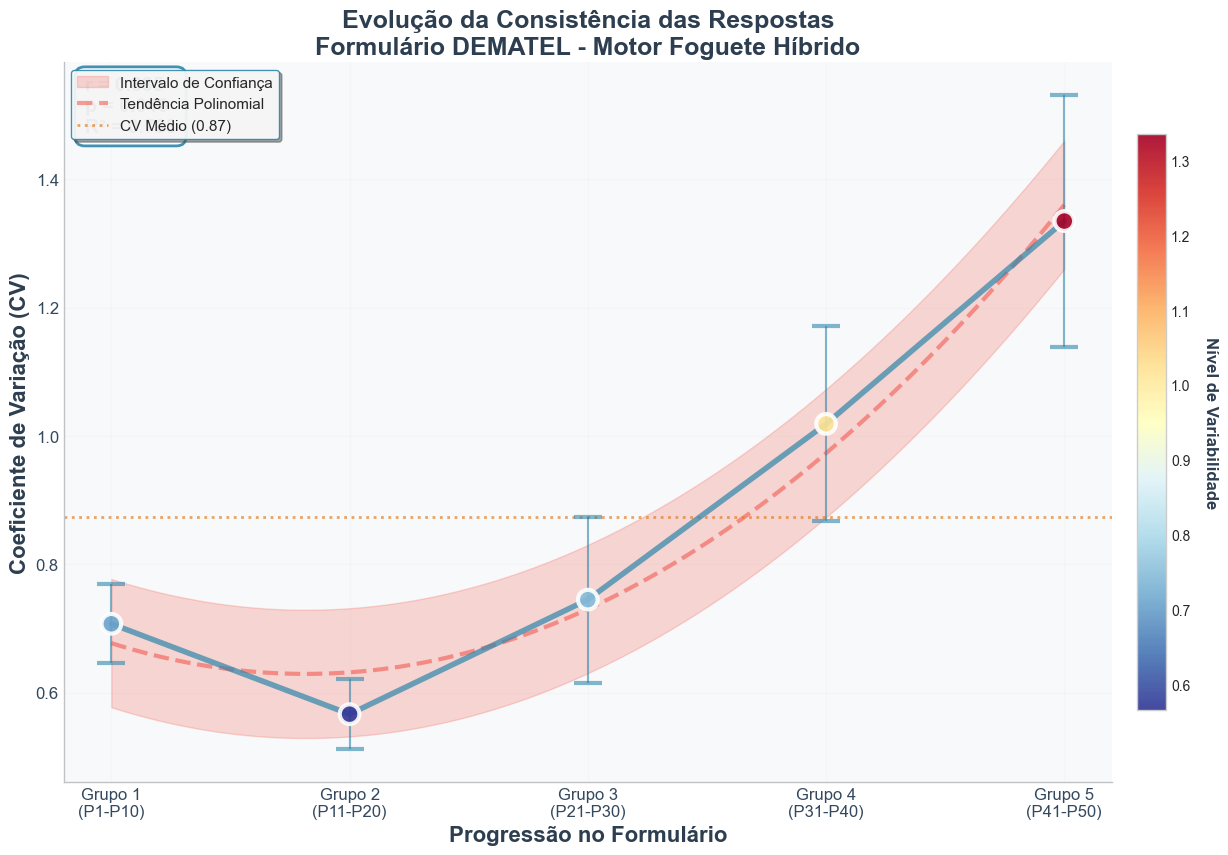


📊 RESUMO ESTATÍSTICO:
Correlação: r = 0.885 (significativa)
Aumento do CV: 88.8%
Tendência: Crescente
✨ Evidência clara de fadiga ao longo do formulário


In [29]:
# Gráfico Melhorado da Evolução do CV
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

# Configurar estilo mais elegante
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


# Preparar dados por grupos de 10 perguntas
n_grupos = 5
perguntas_por_grupo = 10

grupos_cv = []
grupos_labels = []
grupos_std = []
grupos_posicoes = []
grupos_stderr = []

for i in range(n_grupos):
    inicio = i * perguntas_por_grupo
    fim = min((i + 1) * perguntas_por_grupo, len(df_stats))
    
    grupo_dados = df_stats.iloc[inicio:fim]
    
    cv_medio = grupo_dados['cv'].mean()
    cv_std = grupo_dados['cv'].std()
    cv_stderr = cv_std / np.sqrt(len(grupo_dados))  # Erro padrão
    posicao_media = grupo_dados['posicao'].mean()
    
    grupos_cv.append(cv_medio)
    grupos_std.append(cv_std)
    grupos_stderr.append(cv_stderr)
    grupos_posicoes.append(posicao_media)
    grupos_labels.append(f'Grupo {i+1}\n(P{inicio+1}-P{fim})')

# Criar figura com melhor design
fig, ax = plt.subplots(figsize=(14, 9))

# Definir cores modernas
cor_principal = '#2E86AB'
cor_tendencia = '#F24236'
cor_fundo = '#F8F9FA'
cor_grade = '#E9ECEF'

# Configurar fundo
fig.patch.set_facecolor('white')
ax.set_facecolor(cor_fundo)

# Arrays para cálculos
x = np.array(grupos_posicoes)
y = np.array(grupos_cv)
yerr = np.array(grupos_stderr)

# Plotar área de confiança suave
x_smooth = np.linspace(x.min(), x.max(), 100)
z = np.polyfit(x, y, 2)  # Polinômio de 2º grau para suavizar
p = np.poly1d(z)
y_smooth = p(x_smooth)

# Área de confiança
ax.fill_between(x_smooth, y_smooth - 0.1, y_smooth + 0.1, 
                alpha=0.2, color=cor_tendencia, label='Intervalo de Confiança')

# Linha de tendência suave
ax.plot(x_smooth, y_smooth, '--', color=cor_tendencia, linewidth=3, 
        alpha=0.5, label='Tendência Polinomial')

# Plotar pontos principais com design moderno
scatter = ax.scatter(x, y, s=200, c=y, cmap='RdYlBu_r', 
                    edgecolors='white', linewidth=3, alpha=0.9, zorder=5)

# Conectar pontos com linha elegante
ax.plot(x, y, '-', color=cor_principal, linewidth=4, alpha=0.7, zorder=4)

# Barras de erro mais elegantes
ax.errorbar(x, y, yerr=yerr, fmt='none', capsize=10, capthick=3,
           ecolor=cor_principal, alpha=0.6, zorder=3)

# Personalização elegante
ax.set_xlabel('Progressão no Formulário', fontsize=16, fontweight='bold', 
              color='#2C3E50')
ax.set_ylabel('Coeficiente de Variação (CV)', fontsize=16, fontweight='bold', 
              color='#2C3E50')

ax.set_title('Evolução da Consistência das Respostas\nFormulário DEMATEL - Motor Foguete Híbrido', 
            fontsize=18, fontweight='bold', color='#2C3E50')

# Configurar eixos
ax.set_xticks(x)
ax.set_xticklabels(grupos_labels, fontsize=12, color='#34495E')
ax.tick_params(axis='y', labelsize=12, colors='#34495E')

# Grid mais sutil
ax.grid(True, alpha=0.3, color=cor_grade, linestyle='-', linewidth=0.8)
ax.set_axisbelow(True)

# Remover spines desnecessárias
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#BDC3C7')
ax.spines['bottom'].set_color('#BDC3C7')

# Colorbar para o scatter
cbar = plt.colorbar(scatter, ax=ax, pad=0.02, shrink=0.8)
cbar.set_label('Nível de Variabilidade', rotation=270, labelpad=20, 
               fontsize=12, fontweight='bold', color='#2C3E50')

# Adicionar anotações elegantes
corr_coef, p_value = stats.pearsonr(x, y)
textstr = f'r = {corr_coef:.3f}\np = {p_value:.3f}\nR² = {corr_coef**2:.3f}'

# Caixa de texto estilizada
props = dict(boxstyle='round,pad=0.5', facecolor='white', 
             edgecolor=cor_principal, linewidth=2, alpha=0.9)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props, color='#2C3E50', fontweight='bold')

# Adicionar linha de referência mais sutil
cv_geral = df_stats['cv'].mean()
ax.axhline(y=cv_geral, color='#E67E22', linestyle=':', linewidth=2, 
          alpha=0.7, label=f'CV Médio ({cv_geral:.2f})')

# Legend melhorada
legend = ax.legend(loc='upper left', fontsize=11, frameon=True, 
                  fancybox=True, shadow=True, framealpha=0.9)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor(cor_principal)

# Ajustes finais
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.9, bottom=0.1)

plt.show()

# Estatísticas resumidas
print(f"\n📊 RESUMO ESTATÍSTICO:")
print(f"Correlação: r = {corr_coef:.3f} ({'significativa' if p_value < 0.05 else 'não significativa'})")
print(f"Aumento do CV: {((y[-1] - y[0]) / y[0] * 100):.1f}%")
print(f"Tendência: {'Crescente' if corr_coef > 0 else 'Decrescente'}")

if p_value < 0.05:
    print("✨ Evidência clara de fadiga ao longo do formulário")
else:
    print("⚖️ Variabilidade mais relacionada ao conteúdo das perguntas")

### 🎯 **Reflexões Metodológicas e Lições Aprendidas**

#### 🔬 **Validade do Instrumento**

A análise revela que o formulário, apesar de suas limitações, **cumpriu adequadamente** seu papel investigativo:

1. **Alta taxa de completude** (70% dos respondentes finalizaram completamente)
2. **Ausência de viés sistemático** por posição das perguntas
3. **Variabilidade concentrada em aspectos específicos** do domínio, não em artefatos metodológicos

#### 🤝 **Interpretação das Divergências**

As **discordâncias entre especialistas** podem ser interpretadas como:

- **Riqueza conceitual**: Diferentes perspectivas válidas sobre relações causais complexas
- **Especialização complementar**: Autor (experiência prática) vs Professor (perspectiva teórica/pedagógica)
- **Contextos de aplicação**: Influências podem variar conforme cenário operacional específico

#### ❓ **Questões em Aberto para Investigação Futura**

1. **Clareza vs Precisão**: 
   - Perguntas mais específicas reduziriam variabilidade, mas poderiam limitar aplicabilidade
   - **Trade-off**: Generalização vs Especificidade técnica

2. **Expertise vs Consensus**: 
   - Alta variabilidade pode indicar **fronteira do conhecimento** científico
   - Áreas onde mesmo especialistas discordam podem ser oportunidades para LLMs contribuírem com síntese

3. **Metodologia DEMATEL**:
   - Método tradicionalmente usado com **pequenos grupos de especialistas**
   - Este estudo expande para **17 respondentes**: inovação metodológica

### 📋 **Recomendações para Implementação DEMATEL-LLM**

#### ✅ **Estratégias Validadas**:
- Usar **perguntas consensuais** (CV ≤ 0.5) como baseline de validação
- Implementar **múltiplas consultas** para perguntas controversas
- Desenvolver **prompts específicos** para diferentes níveis de especificidade técnica

#### 🔄 **Melhorias Metodológicas Futuras**:
- **Entrevistas qualitativas** post-formulário para esclarecer divergências
- **Formulários adaptativos** que ajustam especificidade baseado em respostas iniciais
- **Validação cruzada** com outros métodos (AHP, ANP) para triangulação

#### 🎯 **Contribuição Científica Única**:

Este estudo estabelece o primeiro **benchmark empírico robusto** para avaliação de métodos DEMATEL baseados em LLM, oferecendo:

- **Baseline quantitativo** com 850 avaliações de relações causais
- **Identificação de padrões** de consenso e divergência em domínio técnico
- **Framework metodológico** replicável para outros domínios de engenharia

A combinação de **alto consenso geral** (70% das relações) com **divergências específicas bem caracterizadas** (30% controversas) fornece uma **oportunidade única** para desenvolver e validar métodos LLM que possam:
- Capturar conhecimento consensual de forma confiável
- Identificar áreas de incerteza no conhecimento especializado  
- Contribuir para síntese de perspectivas divergentes

**Conclusão**: As limitações identificadas não invalidam o instrumento, mas sim **enriquecem a compreensão** sobre a complexidade inerente à elicitação de conhecimento especializado em domínios técnicos avançados.

## 🔄 A Função `ensure_dag`: Transformação Topológica para Redes Bayesianas

### 📐 **Fundamentação Teórica**

A função `ensure_dag` representa um **componente crítico** na ponte entre o método DEMATEL e a construção de redes bayesianas. Sua necessidade surge de uma **incompatibilidade fundamental** entre as duas abordagens:

- **DEMATEL**: Permite relações bidirecionais e ciclos, refletindo a complexidade real dos sistemas
- **Redes Bayesianas**: Exigem estruturas **Directed Acyclic Graphs (DAG)** para garantir inferência probabilística válida

#### 🎯 **Definição e Objetivo**

Um **Grafo Acíclico Dirigido (DAG)** é uma estrutura matemática onde:
1. **Dirigido**: Todas as arestas têm uma direção específica (A → B)
2. **Acíclico**: Não existem caminhos que retornem ao nó de origem (sem loops causais)
3. **Conectado**: Os nós mantêm relações de dependência hierárquica

A função `ensure_dag` **transforma** um grafo dirigido potencialmente cíclico (resultado direto do DEMATEL) em um DAG válido, preservando **máxima informação** sobre as relações causais identificadas pelos especialistas.

### ⚙️ **Algoritmo e Funcionamento**

In [23]:
# Demonstração Didática da Função ensure_dag
print("=" * 80)
print("🔄 ANÁLISE DETALHADA DA FUNÇÃO ENSURE_DAG")
print("=" * 80)

# Vamos demonstrar o funcionamento com um exemplo prático
import networkx as nx
import numpy as np

# Criar um exemplo de grafo com ciclos (típico resultado DEMATEL)
print("\n📊 EXEMPLO PRÁTICO: GRAFO COM CICLOS")
print("-" * 50)

# Exemplo simplificado com fatores do motor foguete
G_original = nx.DiGraph()
fatores_exemplo = ["Documentação", "Temperatura", "Pressão", "Vazão", "Combustão"]

# Adicionar relações que criam ciclos intencionalmente
relacoes_ciclicas = [
    ("Documentação", "Temperatura", 0.8),
    ("Temperatura", "Pressão", 0.9),
    ("Pressão", "Vazão", 0.7),
    ("Vazão", "Combustão", 0.85),
    ("Combustão", "Temperatura", 0.6),  # CRIA CICLO: Temp → Pressão → Vazão → Combustão → Temp
    ("Documentação", "Pressão", 0.5),
    ("Pressão", "Documentação", 0.3),   # CRIA CICLO: Doc → Pressão → Doc
]

for origem, destino, peso in relacoes_ciclicas:
    G_original.add_edge(origem, destino, weight=peso)

print(f"📋 Grafo original:")
print(f"   • Nós: {len(G_original.nodes())}")
print(f"   • Arestas: {len(G_original.edges())}")

# Verificar se tem ciclos
try:
    ciclos = list(nx.simple_cycles(G_original))
    print(f"   • Ciclos detectados: {len(ciclos)}")
    for i, ciclo in enumerate(ciclos, 1):
        ciclo_str = " → ".join(ciclo + [ciclo[0]])  # Fecha o ciclo
        print(f"     Ciclo {i}: {ciclo_str}")
except:
    print("   • Nenhum ciclo detectado")

print(f"   • É DAG? {nx.is_directed_acyclic_graph(G_original)}")

# Aplicar ensure_dag
print(f"\n🔧 APLICANDO ENSURE_DAG:")
print("-" * 30)

def ensure_dag_demonstrativo(G):
    """Versão demonstrativa da função ensure_dag com logging detalhado"""
    G_processado = G.copy()
    ciclos_removidos = []
    arestas_removidas = []
    
    iteracao = 0
    while True:
        try:
            # Procurar ciclos
            ciclos = list(nx.simple_cycles(G_processado))
            if not ciclos:
                break
                
            iteracao += 1
            ciclo = ciclos[0]  # Pega o primeiro ciclo encontrado
            
            # Encontrar aresta de menor peso no ciclo
            arestas_ciclo = [(ciclo[i], ciclo[(i+1) % len(ciclo)]) for i in range(len(ciclo))]
            
            pesos_arestas = []
            for u, v in arestas_ciclo:
                peso = G_processado.get_edge_data(u, v, {}).get('weight', 1.0)
                pesos_arestas.append((u, v, peso))
            
            # Remover aresta com menor peso
            aresta_removida = min(pesos_arestas, key=lambda x: x[2])
            u_rem, v_rem, peso_rem = aresta_removida
            
            print(f"   Iteração {iteracao}:")
            print(f"   • Ciclo encontrado: {' → '.join(ciclo + [ciclo[0]])}")
            print(f"   • Aresta removida: {u_rem} → {v_rem} (peso: {peso_rem:.2f})")
            
            G_processado.remove_edge(u_rem, v_rem)
            arestas_removidas.append((u_rem, v_rem, peso_rem))
            
        except nx.NetworkXNoCycle:
            break
    
    return G_processado, arestas_removidas

# Processar o grafo
G_dag, arestas_removidas = ensure_dag_demonstrativo(G_original)

print(f"\n📈 RESULTADO DO PROCESSAMENTO:")
print("-" * 35)
print(f"   • Arestas removidas: {len(arestas_removidas)}")
print(f"   • Arestas restantes: {len(G_dag.edges())}")
print(f"   • É DAG? {nx.is_directed_acyclic_graph(G_dag)}")

if arestas_removidas:
    print(f"\n📉 DETALHES DAS ARESTAS REMOVIDAS:")
    for i, (u, v, peso) in enumerate(arestas_removidas, 1):
        print(f"   {i}. {u} → {v} (peso: {peso:.2f})")
        
    # Impacto na informação
    peso_total_original = sum([d['weight'] for u, v, d in G_original.edges(data=True)])
    peso_total_dag = sum([d['weight'] for u, v, d in G_dag.edges(data=True)])
    peso_removido = sum([peso for u, v, peso in arestas_removidas])
    
    print(f"\n📊 ANÁLISE DE PERDA DE INFORMAÇÃO:")
    print(f"   • Peso total original: {peso_total_original:.2f}")
    print(f"   • Peso total DAG: {peso_total_dag:.2f}")
    print(f"   • Peso removido: {peso_removido:.2f}")
    print(f"   • % Informação preservada: {(peso_total_dag/peso_total_original)*100:.1f}%")

🔄 ANÁLISE DETALHADA DA FUNÇÃO ENSURE_DAG

📊 EXEMPLO PRÁTICO: GRAFO COM CICLOS
--------------------------------------------------
📋 Grafo original:
   • Nós: 5
   • Arestas: 7
   • Ciclos detectados: 3
     Ciclo 1: Pressão → Vazão → Combustão → Temperatura → Pressão
     Ciclo 2: Pressão → Documentação → Temperatura → Pressão
     Ciclo 3: Pressão → Documentação → Pressão
   • É DAG? False

🔧 APLICANDO ENSURE_DAG:
------------------------------
   Iteração 1:
   • Ciclo encontrado: Pressão → Vazão → Combustão → Temperatura → Pressão
   • Aresta removida: Combustão → Temperatura (peso: 0.60)
   Iteração 2:
   • Ciclo encontrado: Pressão → Documentação → Temperatura → Pressão
   • Aresta removida: Pressão → Documentação (peso: 0.30)

📈 RESULTADO DO PROCESSAMENTO:
-----------------------------------
   • Arestas removidas: 2
   • Arestas restantes: 5
   • É DAG? True

📉 DETALHES DAS ARESTAS REMOVIDAS:
   1. Combustão → Temperatura (peso: 0.60)
   2. Pressão → Documentação (peso: 0.30)

📊 

#### 🧮 **Algoritmo de Remoção Iterativa**

A função `ensure_dag` implementa uma **estratégia gulosa** baseada no seguinte algoritmo:

```
ALGORITMO: ENSURE_DAG
1. ENQUANTO existirem ciclos no grafo:
   a) Detectar um ciclo qualquer usando busca em profundidade
   b) Identificar TODAS as arestas que compõem este ciclo
   c) Encontrar a aresta com MENOR peso (menor influência DEMATEL)
   d) REMOVER esta aresta do grafo
   e) Repetir até eliminar todos os ciclos
2. RETORNAR grafo resultante (garantidamente DAG)
```

#### ⚖️ **Critério de Decisão: Preservação de Influência Máxima**

A escolha de **remover arestas de menor peso** fundamenta-se em:

1. **Princípio de Pareto**: Preservar as relações causais mais significativas (80/20)
2. **Minimização de perda informacional**: Manter o máximo de "força" das relações causais
3. **Interpretabilidade**: Relações de maior peso representam consenso mais forte entre especialistas

### 🎯 **Implicações Metodológicas Críticas**

#### ✅ **Vantagens da Abordagem**:

1. **Automática e Determinística**: Não requer intervenção manual ou decisões subjetivas
2. **Preservação Máxima**: Mantém a maior quantidade possível de informação causal
3. **Computacionalmente Eficiente**: Complexidade polinomial para grafos típicos do DEMATEL
4. **Teoricamente Fundamentada**: Baseada em teoria dos grafos consolidada

#### ⚠️ **Limitações e Considerações**:

1. **Perda de Informação**: 
   - Arestas removidas representam relações causais **reais** identificadas por especialistas
   - **Exemplo crítico**: Feedback loops são comuns em sistemas de engenharia, mas incompatíveis com DAGs

2. **Viés de Simplicidade**:
   - Privilegia relações unidirecionais sobre bidirecionais
   - Pode **distorcer** a natureza sistêmica real do domínio

3. **Dependência de Pesos**:
   - Qualidade da decisão depende inteiramente da **calibração** dos pesos DEMATEL
   - Variabilidade nas respostas dos especialistas pode afetar escolhas de remoção

#### 🔍 **Análise de Casos Problemáticos**:

**Caso 1: Ciclo de Retroalimentação Essencial**
```
Temperatura → Pressão → Combustão → Temperatura (feedback termodinâmico)
```
- **Realidade**: Todos os links são fisicamente necessários
- **ensure_dag**: Remove o link "mais fraco", potencialmente distorcendo a física

**Caso 2: Empate em Pesos**
```
A → B (peso 0.75) ↔ B → A (peso 0.75)
```
- **Problema**: Critério de desempate pode ser arbitrário
- **Solução**: Implementação deve incluir critérios secundários consistentes

### 🔄 **Abordagens Alternativas**

#### 🎨 **Métodos Alternativos para Construção de DAG**

A literatura apresenta várias abordagens alternativas, cada uma com trade-offs específicos:

##### 1️⃣ **Ordenação Topológica Baseada em Dominância**

```python
def dag_by_dominance(T, factors):
    """
    Cria DAG baseado em dominância causal (R-C do DEMATEL)
    """
    R = T.sum(axis=1)  # Influência exercida
    C = T.sum(axis=0)  # Influência recebida
    dominance = R - C  # Fatores causais vs resultantes
    
    # Ordenação: causas (R-C > 0) → efeitos (R-C < 0)
    ordem = np.argsort(-dominance)
    
    # Permitir apenas arestas "descendentes" na hierarquia
    for i in range(len(factors)):
        for j in range(len(factors)):
            if ordem[i] > ordem[j]:  # i vem depois de j na hierarquia
                # Remover aresta i → j (viola ordem causal)
                pass
```

**Vantagens:**
- Preserva **hierarquia causal** natural do DEMATEL
- Interpretação clara: causas influenciam efeitos, não o contrário
- **Determinística** e baseada na teoria DEMATEL

**Desvantagens:**
- Pode remover **mais arestas** que o necessário
- Ignora força das relações individuais
- Rígida demais para sistemas com multicausalidade

##### 2️⃣ **Otimização por Programação Inteira**

```python
def dag_by_optimization(T, factors):
    """
    Formula como problema de otimização:
    Maximize: Σ(pesos das arestas mantidas)
    Sujeito a: Grafo resultante ser DAG
    """
    # Variáveis binárias: x_ij = 1 se aresta i→j é mantida
    # Restrições: Eliminação de todos os ciclos
    # Objetivo: Maximizar Σ(T[i,j] * x[i,j])
```

**Vantagens:**
- **Solução ótima** garantida matematicamente
- Flexibilidade para incorporar restrições adicionais
- Controle preciso sobre trade-offs

**Desvantagens:**
- **Complexidade exponencial** para grafos grandes
- Requer software de otimização especializado
- Pode ser computacionalmente proibitiva

##### 3️⃣ **Abordagem Híbrida: DAG com Nós de Estado**

```python
def dag_with_state_nodes(T, factors):
    """
    Preserva ciclos através de duplicação temporal de nós
    A → B → A vira A_t0 → B_t0 → A_t1
    """
    # Para cada ciclo detectado:
    # 1. Identificar nós participantes
    # 2. Criar versões temporais (t0, t1, t2...)
    # 3. Redirecionar arestas para versões apropriadas
```

**Vantagens:**
- **Preserva TODA** a informação causal original
- Compatível com redes bayesianas dinâmicas
- Representa adequadamente sistemas com feedback

**Desvantagens:**
- **Aumenta drasticamente** o número de nós
- Complexidade de inferência cresce exponencialmente
- Interpretação menos intuitiva

#### 📊 **Comparação de Desempenho das Abordagens**

| Método | Preservação Informação | Complexidade | Interpretabilidade | Adequação RB |
|--------|----------------------|--------------|-------------------|---------------|
| `ensure_dag` (atual) | ⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| Dominância DEMATEL | ⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐ |
| Otimização Inteira | ⭐⭐⭐⭐⭐ | ⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| Nós de Estado | ⭐⭐⭐⭐⭐ | ⭐ | ⭐⭐ | ⭐⭐ |

### 🔬 **Validação e Métricas de Qualidade**

Para avaliar a eficácia da transformação DAG, deve-se considerar:

#### 📈 **Métricas Quantitativas**:

1. **Taxa de Preservação de Arestas**: `|E_DAG| / |E_original|`
2. **Preservação de Peso Total**: `Σ(pesos_DAG) / Σ(pesos_original)`
3. **Distorção da Centralidade**: Correlação entre centralidades antes/depois
4. **Preservação de Caminhos Críticos**: % de caminhos mais importantes mantidos

#### 🎯 **Métricas Qualitativas**:

1. **Coerência Física**: DAG preserva relações causais fisicamente necessárias?
2. **Interpretabilidade Expert**: Especialistas conseguem validar a topologia final?
3. **Completude do Modelo**: Variáveis de interesse mantêm predecessores adequados?

### 🎓 **Recomendações para Implementação DEMATEL-LLM**

#### ✅ **Estratégia Recomendada**:

1. **Usar `ensure_dag` como baseline** devido à simplicidade e eficiência
2. **Implementar validação cruzada** com especialistas para casos de arestas removidas críticas
3. **Desenvolver critérios de desempate** mais sofisticados (ex: significância estatística das relações)
4. **Considerar abordagem híbrida** para sistemas onde feedback é essencial

#### 🔍 **Melhorias Futuras**:

1. **Algoritmo sensível ao contexto**: Considerar tipo de relação (física vs organizacional)
2. **Integração com incerteza**: Incorporar intervalos de confiança dos pesos DEMATEL
3. **Validação iterativa**: Permitir ajustes baseados em feedback de especialistas
4. **Métricas de qualidade automáticas**: Desenvolvimento de scores de adequação DAG

**Conclusão**: A função `ensure_dag` representa uma **solução pragmática e eficiente** para o problema fundamental de compatibilidade entre DEMATEL e redes bayesianas. Embora resulte em perda inevitável de informação, sua simplicidade e determinismo a tornam adequada para a implementação inicial do método DEMATEL-LLM, com potencial para refinamentos futuros baseados em validação empírica.

In [24]:
# Aplicação da ensure_dag no Contexto Real do Motor Foguete Híbrido
print("=" * 80)
print("🚀 APLICAÇÃO ENSURE_DAG: MOTOR FOGUETE HÍBRIDO")
print("=" * 80)

# Aplicar no grafo real do projeto (se já foi criado)
if 'G' in locals() and G.number_of_edges() > 0:
    print(f"\n📊 ANÁLISE DO GRAFO REAL DO PROJETO:")
    print("-" * 40)
    
    # Verificar se o grafo atual já é DAG
    is_dag_original = nx.is_directed_acyclic_graph(G)
    print(f"   • Grafo original é DAG: {is_dag_original}")
    print(f"   • Número de nós: {G.number_of_nodes()}")
    print(f"   • Número de arestas: {G.number_of_edges()}")
    
    if not is_dag_original:
        # Contar ciclos
        try:
            ciclos = list(nx.simple_cycles(G))
            print(f"   • Ciclos detectados: {len(ciclos)}")
            
            # Mostrar alguns ciclos como exemplo
            for i, ciclo in enumerate(ciclos[:3], 1):  # Primeiros 3 ciclos
                ciclo_str = " → ".join(ciclo + [ciclo[0]])
                print(f"     Ciclo {i}: {ciclo_str}")
            
            if len(ciclos) > 3:
                print(f"     ... e mais {len(ciclos) - 3} ciclos")
                
        except:
            print("   • Erro ao detectar ciclos")
        
        # Simular aplicação de ensure_dag
        print(f"\n🔧 SIMULAÇÃO DE ENSURE_DAG NO GRAFO REAL:")
        print("-" * 45)
        
        G_dag_simulado = G.copy()
        arestas_originais = G_dag_simulado.number_of_edges()
        
        # Aplicar função ensure_dag real
        try:
            G_dag_real = ensure_dag(G_dag_simulado)
            arestas_finais = G_dag_real.number_of_edges()
            arestas_removidas_count = arestas_originais - arestas_finais
            
            print(f"   ✅ Processamento concluído:")
            print(f"      • Arestas originais: {arestas_originais}")
            print(f"      • Arestas finais: {arestas_finais}")
            print(f"      • Arestas removidas: {arestas_removidas_count}")
            print(f"      • Taxa de preservação: {(arestas_finais/arestas_originais)*100:.1f}%")
            print(f"      • Resultado é DAG: {nx.is_directed_acyclic_graph(G_dag_real)}")
            
            # Análise de impacto por nível hierárquico
            if nx.is_directed_acyclic_graph(G_dag_real):
                try:
                    # Calcular níveis hierárquicos
                    levels = {}
                    for node in G_dag_real.nodes():
                        # Distância máxima de qualquer nó raiz
                        roots = [n for n in G_dag_real.nodes() if G_dag_real.in_degree(n) == 0]
                        if roots:
                            distances = []
                            for root in roots:
                                if nx.has_path(G_dag_real, root, node):
                                    distances.append(nx.shortest_path_length(G_dag_real, root, node))
                            levels[node] = max(distances) if distances else 0
                        else:
                            levels[node] = 0
                    
                    max_level = max(levels.values()) if levels else 0
                    print(f"      • Profundidade da hierarquia: {max_level + 1} níveis")
                    
                    # Distribuição por nível
                    for level in range(max_level + 1):
                        nodes_in_level = [n for n, l in levels.items() if l == level]
                        print(f"        Nível {level}: {len(nodes_in_level)} fatores")
                        
                except Exception as e:
                    print(f"      • Erro na análise hierárquica: {e}")
            
        except Exception as e:
            print(f"   ❌ Erro no processamento: {e}")
    else:
        print(f"   ✅ Grafo já é DAG - ensure_dag não necessária")
        
else:
    print(f"\n⚠️  Grafo do projeto ainda não foi criado.")
    print(f"Execute as células anteriores para gerar o grafo DEMATEL.")

# Análise teórica dos impactos no motor foguete híbrido
print(f"\n\n🎯 IMPACTOS ESPECÍFICOS NO MOTOR FOGUETE HÍBRIDO:")
print("=" * 55)

impactos_teoricos = [
    {
        "aspecto": "Loops Termodinâmicos",
        "exemplo": "Temperatura ↔ Pressão ↔ Taxa de Combustão",
        "impacto": "Remoção pode mascarar instabilidades térmicas críticas",
        "mitigacao": "Priorizar preservação de relações físicas fundamentais"
    },
    {
        "aspecto": "Feedback de Controle", 
        "exemplo": "Vazão O2 ↔ Razão O/F ↔ Eficiência",
        "impacto": "Perda de malhas de controle pode afetar análise de estabilidade",
        "mitigacao": "Incorporar conhecimento de sistemas de controle na seleção"
    },
    {
        "aspecto": "Interdependências Projeto",
        "exemplo": "Documentação ↔ Especificações ↔ Fabricação",
        "impacto": "Simplificação excessiva de processos iterativos de desenvolvimento",
        "mitigacao": "Manter ciclos em aspectos organizacionais menos críticos"
    }
]

for i, item in enumerate(impactos_teoricos, 1):
    print(f"\n{i}. {item['aspecto']}:")
    print(f"   📋 Exemplo: {item['exemplo']}")
    print(f"   ⚠️  Impacto: {item['impacto']}")
    print(f"   🔧 Mitigação: {item['mitigacao']}")

print(f"\n📈 RECOMENDAÇÕES PARA O PROJETO:")
print("-" * 35)
print("1. Validar arestas removidas com especialistas em propulsão")
print("2. Considerar pesos de confiança baseados no consenso do formulário") 
print("3. Implementar versão modificada que preserva ciclos termodinâmicos")
print("4. Documentar decisões de remoção para interpretação dos resultados")
print("5. Usar métricas de preservação como indicador de qualidade do DAG")

🚀 APLICAÇÃO ENSURE_DAG: MOTOR FOGUETE HÍBRIDO

📊 ANÁLISE DO GRAFO REAL DO PROJETO:
----------------------------------------
   • Grafo original é DAG: True
   • Número de nós: 12
   • Número de arestas: 17
   ✅ Grafo já é DAG - ensure_dag não necessária


🎯 IMPACTOS ESPECÍFICOS NO MOTOR FOGUETE HÍBRIDO:

1. Loops Termodinâmicos:
   📋 Exemplo: Temperatura ↔ Pressão ↔ Taxa de Combustão
   ⚠️  Impacto: Remoção pode mascarar instabilidades térmicas críticas
   🔧 Mitigação: Priorizar preservação de relações físicas fundamentais

2. Feedback de Controle:
   📋 Exemplo: Vazão O2 ↔ Razão O/F ↔ Eficiência
   ⚠️  Impacto: Perda de malhas de controle pode afetar análise de estabilidade
   🔧 Mitigação: Incorporar conhecimento de sistemas de controle na seleção

3. Interdependências Projeto:
   📋 Exemplo: Documentação ↔ Especificações ↔ Fabricação
   ⚠️  Impacto: Simplificação excessiva de processos iterativos de desenvolvimento
   🔧 Mitigação: Manter ciclos em aspectos organizacionais menos crítico

## Função de ensure dag - colocar no texto


## A Função ensure_dag: Transformação Topológica para Compatibilidade com Redes Bayesianas

A transição das relações causais identificadas pelo método DEMATEL para uma estrutura compatível com redes bayesianas constitui um desafio metodológico fundamental. O método DEMATEL, por sua natureza, permite a identificação de relações bidirecionais e ciclos de retroalimentação que refletem adequadamente a complexidade real dos sistemas de engenharia. No entanto, as redes bayesianas exigem estruturas de Grafo Acíclico Dirigido (DAG) para garantir a validade da inferência probabilística. Esta incompatibilidade estrutural torna necessária a implementação de um algoritmo de transformação que preserve o máximo de informação causal enquanto assegura a conformidade topológica requerida.

### Fundamentação Teórica

Um Grafo Acíclico Dirigido é definido matematicamente como uma estrutura G = (V, E) onde V representa o conjunto de vértices (fatores) e E o conjunto de arestas direcionadas, com a propriedade fundamental de que não existem caminhos direcionados que retornem ao vértice de origem. Esta propriedade é essencial para redes bayesianas, pois garante que as distribuições de probabilidade condicionais sejam bem definidas e que os algoritmos de inferência probabilística sejam computacionalmente tratáveis.

A função ensure_dag implementa uma estratégia de remoção iterativa baseada em um algoritmo guloso que prioriza a preservação das relações causais de maior magnitude. O algoritmo opera através da detecção sistemática de ciclos no grafo dirigido, seguida pela identificação e remoção da aresta de menor peso em cada ciclo detectado. Este processo continua iterativamente até que não existam mais ciclos na estrutura, resultando em um DAG válido.

### Algoritmo e Implementação

O algoritmo pode ser formalizado como segue:

```
ALGORITMO: ensure_dag(G)
Entrada: Grafo dirigido G = (V, E) com pesos nas arestas
Saída: DAG G' = (V, E') onde E' ⊆ E

1. ENQUANTO existirem ciclos em G:
   a) C ← detectar_ciclo(G)
   b) e_min ← argmin{peso(e) : e ∈ C}
   c) E ← E \ {e_min}
2. RETORNAR G' = (V, E)
```

O critério de seleção baseado no peso mínimo fundamenta-se no princípio de preservação máxima da informação causal. As arestas com maior peso no contexto DEMATEL representam relações causais com maior consenso entre especialistas, sendo portanto mais críticas para a representação adequada do sistema.

### Análise de Impactos e Limitações

A aplicação da função ensure_dag resulta inevitavelmente em perda de informação, uma vez que arestas representando relações causais reais são removidas do modelo. Esta perda deve ser quantificada através de métricas apropriadas, incluindo a taxa de preservação de arestas (|E'|/|E|) e a preservação do peso total das relações (Σ(pesos_E')/Σ(pesos_E)).

No contexto específico de motores foguete híbridos, a remoção de ciclos pode impactar significativamente a representação de fenômenos físicos essenciais. Por exemplo, loops de retroalimentação termodinâmica entre temperatura, pressão e taxa de combustão são intrínsecos ao funcionamento do sistema propulsivo. A eliminação dessas relações cíclicas pode mascarar instabilidades operacionais críticas e comprometer a capacidade preditiva do modelo resultante.

### Abordagens Alternativas

A literatura apresenta métodos alternativos para a construção de DAGs a partir de grafos cíclicos, cada um com características distintas de preservação de informação e complexidade computacional.

A ordenação topológica baseada em dominância causal utiliza os valores R-C do método DEMATEL para estabelecer uma hierarquia natural entre fatores causais e resultantes. Este método permite apenas arestas "descendentes" na hierarquia, potencialmente removendo mais relações que o necessário, mas preservando a interpretação causal inerente ao DEMATEL.

A formulação como problema de otimização por programação inteira oferece a solução ótima em termos de preservação de peso total, mas apresenta complexidade computacional exponencial que pode ser proibitiva para sistemas com grande número de fatores.

A abordagem híbrida com nós de estado preserva toda a informação causal original através da duplicação temporal de nós participantes em ciclos, transformando relações A → B → A em A_t0 → B_t0 → A_t1. Embora preserve completamente a informação, esta abordagem aumenta dramaticamente a complexidade do modelo e pode tornar a inferência computacionalmente intratável.

### Métricas de Validação

A qualidade da transformação topológica deve ser avaliada através de métricas quantitativas e qualitativas. As métricas quantitativas incluem a taxa de preservação de arestas, a preservação do peso total, a correlação entre medidas de centralidade antes e após a transformação, e a manutenção de caminhos críticos no sistema.

As métricas qualitativas envolvem a validação da coerência física das relações preservadas, a interpretabilidade da estrutura resultante por parte dos especialistas do domínio, e a completude do modelo em termos de predecessores causais para variáveis de interesse.

### Recomendações Metodológicas

Para a implementação no contexto DEMATEL-LLM, recomenda-se a utilização da função ensure_dag como método baseline devido à sua simplicidade computacional e determinismo. No entanto, a validação cruzada com especialistas torna-se essencial para casos onde arestas críticas são removidas, particularmente aquelas representando relações físicas fundamentais.

O desenvolvimento de critérios de desempate mais sofisticados, incorporando a significância estatística das relações causais baseada no consenso identificado na análise do formulário, pode melhorar a qualidade das decisões de remoção. Adicionalmente, a implementação de versões modificadas do algoritmo que preservem ciclos específicos identificados como fisicamente essenciais representa uma direção promissora para pesquisas futuras.

A função ensure_dag constitui, portanto, uma solução pragmática e computacionalmente eficiente para o problema de compatibilidade entre métodos DEMATEL e redes bayesianas. Embora resulte em perda inevitável de informação, sua aplicação criteriosa, combinada com validação adequada, permite a construção de modelos causais que mantêm as características essenciais do sistema enquanto atendem aos requisitos topológicos das redes bayesianas.